
# Data Loading Section

In [1]:
# import important libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from math import floor
import os
import torchvision.models
import copy

use_cuda = True #enable usage of cuda GPU
torch.manual_seed(1000)

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Loading the data 
#Toby's file directory paths (Note the MyDrive)
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/test.zip' -d '/root/datasets'
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/train.zip' -d '/root/datasets'
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/val.zip' -d '/root/datasets'
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/tiny.zip' -d '/root/datasets'



Archive:  /content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/test.zip
  inflating: /root/datasets/test/compost_other/O_2130.jpg  
  inflating: /root/datasets/test/compost_other/compost_tampons (18).jpg  
  inflating: /root/datasets/test/compost_other/O_5547.jpg  
  inflating: /root/datasets/test/compost_other/O_2511.jpg  
  inflating: /root/datasets/test/compost_other/O_2060.jpg  
  inflating: /root/datasets/test/garbage/more_wrap (3).jpg  
  inflating: /root/datasets/test/compost_other/O_2891.jpg  
  inflating: /root/datasets/test/compost_other/gbg_wrappers_papertowels (48).jpg  
  inflating: /root/datasets/test/compost_other/O_2674.jpg  
  inflating: /root/datasets/test/compost_other/O_2610.jpg  
  inflating: /root/datasets/test/garbage/gbgblackplastic (45).jpg  
  inflating: /root/datasets/test/compost_other/download (2).jpg  
  inflating: /root/datasets/test/compost_other/images (17).jpg  
  inflating: /root/datasets/test/garbage/gbg_wrappers_papertowels (83).jpg  
  inf

In [ ]:
# Loading the data
# Everyone else's file directory paths (Note the SharedDrive)
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/test.zip' -d '/root/datasets'
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/train.zip' -d '/root/datasets'
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/val.zip' -d '/root/datasets'
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/tiny.zip' -d '/root/datasets'


unzip:  cannot find or open /content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/test.zip, /content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/test.zip.zip or /content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/test.zip.ZIP.
unzip:  cannot find or open /content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/train.zip, /content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/train.zip.zip or /content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/train.zip.ZIP.
unzip:  cannot find or open /content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/val.zip, /content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/val.zip.zip or /content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/val.zip.ZIP.
unzip:  cannot find or open /content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/tiny.zip, /content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/tiny.zip.zip or /cont

In [4]:
train_path = '/root/datasets/train'
val_path = '/root/datasets/val'
test_path = '/root/datasets/test'
tiny_path = '/root/datasets/tiny'

In [5]:
# Load the tensors
transformations = transforms.Compose([                                     
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])
train_set = torchvision.datasets.ImageFolder(train_path, transform = transformations)
val_set = torchvision.datasets.ImageFolder(val_path, transform = transformations)
test_set = torchvision.datasets.ImageFolder(test_path, transform = transformations)
tiny_set = torchvision.datasets.ImageFolder(tiny_path, transform = transformations)

# Model and Training Functions and Classes

In [6]:
'''
Functions for training and getting accuracy
'''
def train(model, train_set, val_set, batch_size=64, num_epochs=1, learning_rate=0.001, optimizer_selection="SGD"):
  iters = np.zeros(num_epochs)
  losses = np.zeros(num_epochs)
  train_acc = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)

  # Fixed PyTorch random seed for reproducible result
  torch.manual_seed(1000)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)#, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)#, shuffle=True)

  #get the parameters that require updating
  params_to_update = []
  for name,param in model.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)      

  #use Cross entropy loss and SGD or Adam depending on user input
  criterion = nn.CrossEntropyLoss()
  if (optimizer_selection == "SGD"):
    optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)
  elif (optimizer_selection == "Adam"):
    optimizer = optim.Adam(params_to_update, lr=learning_rate)
  else:
    optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)

  # training
  n = 0 # the number of iterations
  for epoch in range(num_epochs):
      for i, data in enumerate(train_loader, 0):
          imgs, labels = data 
        
          #############################################
          #To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
          #############################################
          
            
          out = model(imgs)             # forward pass
          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean up step for PyTorch
          n += 1

      # save the current training information
      iters[epoch] = epoch 
      losses[epoch] = (float(loss)/batch_size)             # compute *average* loss
      train_acc[epoch] = get_accuracy(model, train_loader) # compute training accuracy 
      val_acc[epoch] = get_accuracy(model, val_loader)  # compute validation accuracy

          
          

      #printing out data
      if epoch % 10==0:
        print(("Epoch {}: Train accuracy: {}, Training Loss: {}, Validation Accuracy: {}").format(
                    epoch + 1,
                    train_acc[epoch],
                    losses[epoch],
                    val_acc[epoch]))

      # Save the current model (checkpoint) to a file
      if hasattr(model, 'name'):
        name = model.name
      else:
        name = "WasteNet"
      model_path = get_model_name(name, batch_size, learning_rate, epoch)
      torch.save(model.state_dict(), model_path)


  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

# calculates accuracy
def get_accuracy(model, loader):
  correct = 0
  total = 0
  for imgs, labels in loader:    
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################        
      output = model(imgs)
      
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
  return correct / total

def get_accuracy_of_label(model, loader, label):
  correct = 0
  total = 0
  for imgs, labels in loader:    
      if label ==labels.numpy()[0]:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
  return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
  """ Generate a name for the model consisting of all the hyperparameter values

  Args:
      config: Configuration object containing the hyperparameters
  Returns:
      path: A string with the hyperparameter name and value concatenated
  """
  path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                  batch_size,
                                                  learning_rate,
                                                  epoch)
  return path  

In [7]:
train_set.classes

['compost_food',
 'compost_other',
 'garbage',
 'recy_bags',
 'recy_bottles',
 'recy_cans',
 'recy_cups',
 'recy_other_containers',
 'recy_paper',
 'recy_styrofoam']

In [8]:
def get_label_equals(prediction, label):
    if prediction == 0 or prediction == 1:
      if label == 0 or label == 1:
        return 1
    elif prediction == 2:
      if label == 2:
        return 1
    elif prediction == 3 or prediction == 4 or prediction == 5 or prediction == 6 or prediction == 7 or prediction == 8 or prediction == 9:
      if label == 3 or label == 4 or label == 5 or label == 6 or label == 7 or label == 8 or label == 9:
        return 1
    return 0


In [9]:
def get_sorting_accuracy(model, loader, thresh):
  correct = 0
  total = 0
  for imgs, labels in loader:    
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
      #############################################        
      output = model(imgs)
      
      #select index with maximum prediction score
      max_out = output.max(1, keepdim=True)
      if max_out[0] >= thresh:
        pred = max_out[1]
      else:
        pred = [2]
      correct += get_label_equals(pred[0], labels)
      total += imgs.shape[0]
  return correct / total

In [10]:
# Models for transfer learning
resnet18 = torchvision.models.resnet18(pretrained=True)
alexnet = torchvision.models.alexnet(pretrained=True)
googlenet = torchvision.models.googlenet(pretrained=True)
resnet152 = torchvision.models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [11]:
# function to transfer learning model features as tensors into folder
def save_features(model, model_name, dataset, directory, classes, num_iter=1):
  '''
  model: the chosen transfer learning model
  directory: This is the directory where we want to save the tensors
  dataset: pass in tensor dataset
  classes: pass in array of list of classes'''
  
  torch.manual_seed(1000)
  loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=1)
  os.mkdir(directory)

  n = 0 # use this to track the number of the file
  for i in range(num_iter):
    for imgs, labels in loader:
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
        
      # extract features and save as tensors
      features = model(imgs)
      if use_cuda and torch.cuda.is_available():
        tensor_features = torch.from_numpy(features.cpu().detach().numpy())
      else:
        tensor_features = torch.from_numpy(features.detach().numpy())

      #create the class directory if it doesn't exist
      if (not os.path.exists(directory + '/' + classes[labels])):
        os.mkdir(directory + '/' + classes[labels])

      #save tensor file as a file
      #can be saved as a .pt file: https://pytorch.org/docs/stable/generated/torch.save.html
      torch.save(tensor_features.squeeze(0), directory + '/' + classes[labels] + '/' + model_name + '_' + str(n) + '.pt')

      n = n+1

In [23]:
class Waste_Classifier_ANN(nn.Module):
  def __init__(self, name="WasteNet", hidden_size=256*6*6, actual_hidden_size=50):
    super(Waste_Classifier_ANN, self).__init__()
    self.name = name
    self.fc1 = nn.Linear(hidden_size, actual_hidden_size)
    self.fc2 = nn.Linear(actual_hidden_size, 10)
    self.hidden_size = hidden_size

  def forward(self, x):
    x = x.view(-1, self.hidden_size) #flatten feature data
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [22]:
class Waste_Classifier_MLP(nn.Module):
  def __init__(self, name="WasteNet", hidden_size=256*6*6):
    super(Waste_Classifier_MLP, self).__init__()
    self.name = name
    self.fc1 = nn.Linear(hidden_size, 50)
    self.fc2 = nn.Linear(50, 30)
    self.fc3 = nn.Linear(30, 10)
    self.hidden_size = hidden_size

  def forward(self, x):
    #print(x.shape)
    x = x.view(-1, self.hidden_size) #flatten feature data
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [21]:
class Waste_Classifier_CNN(nn.Module):

      def __init__(self,name="WasteNetCNN", hidden_size=256, filtered_dim_size=4):
          self.name = name
          super(Waste_Classifier_CNN, self).__init__()
          self.conv1 = nn.Conv2d(hidden_size, 600, 2) #in_channels, out_chanels, kernel_size
          self.conv2 = nn.Conv2d(600, 1000, 2) #in_channels, out_chanels, kernel_size
          
          self.fc1 = nn.Linear(1000*filtered_dim_size*filtered_dim_size, 64)         
          self.fc2 = nn.Linear(64, 10)
          self.hidden_size = hidden_size
          self.filtered_dim_size = filtered_dim_size

      def forward(self, x):
          x = F.relu(self.conv1(x))
          x = F.relu(self.conv2(x))
          x = x.view(-1, 1000*self.filtered_dim_size*self.filtered_dim_size)         
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

In [20]:
class Waste_Classifier_CNN_With_Pool(nn.Module):

      def __init__(self,name="WasteNetCNNWithPool", hidden_size=256, filtered_dim_size=4):
          self.name = name
          super(Waste_Classifier_CNN_With_Pool, self).__init__()
          self.conv1 = nn.Conv2d(hidden_size, 600, 2) #in_channels, out_chanels, kernel_size
          self.conv2 = nn.Conv2d(600, 1000, 2) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
          self.fc1 = nn.Linear(1000*filtered_dim_size*filtered_dim_size, 64)         
          self.fc2 = nn.Linear(64, 10)
          self.hidden_size = hidden_size
          self.filtered_dim_size = filtered_dim_size

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 1000*self.filtered_dim_size*self.filtered_dim_size)         
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x


In [19]:
class Waste_Classifier_One_CNN_Layer(nn.Module):

      def __init__(self,name="WasteNetSingleCNNWithPool", hidden_size=256, filtered_dim_size=3):
          self.name = name
          super(Waste_Classifier_One_CNN_Layer, self).__init__()
          self.conv1 = nn.Conv2d(hidden_size, 600, 2) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
          self.fc1 = nn.Linear(600*filtered_dim_size*filtered_dim_size, 64)         
          self.fc2 = nn.Linear(64, 10)
          
          self.hidden_size = hidden_size
          self.filtered_dim_size = filtered_dim_size

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = x.view(-1, 600*self.filtered_dim_size*self.filtered_dim_size)      
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

In [18]:
class Waste_Classifier_One_Linear_Layer(nn.Module):
  def __init__(self, name="WasteNet", hidden_size=256*6*6):
    super(Waste_Classifier_One_Linear_Layer, self).__init__()
    self.name = name
    self.fc1 = nn.Linear(hidden_size, 10)
    self.hidden_size = hidden_size

  def forward(self, x):
    x = x.view(-1, self.hidden_size) #flatten feature data
    x = self.fc1(x)
    return x

# Predictions and Testing --> AlexNet

In [ ]:
# save Alex Net features first: Trying this model first
data_dir = '/root/datasets/AlexNet/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

os.mkdir(data_dir)
model = alexnet.features
save_features(model, "alexnet", tiny_set, tiny_dir, tiny_set.classes)
save_features(model, "alexnet", train_set, train_dir, train_set.classes)
save_features(model, "alexnet", val_set, val_dir, val_set.classes)
save_features(model, "alexnet", test_set, test_dir, test_set.classes)


In [ ]:
feature_tiny_set = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.26666666666666666, Training Loss: 0.07695200443267822, Validation Accuracy: 0.26666666666666666
Epoch 2: Train accuracy: 0.43333333333333335, Training Loss: 0.07317289511362711, Validation Accuracy: 0.43333333333333335
Epoch 3: Train accuracy: 0.8, Training Loss: 0.06731022993723551, Validation Accuracy: 0.8
Epoch 4: Train accuracy: 0.9333333333333333, Training Loss: 0.060487449169158936, Validation Accuracy: 0.9333333333333333
Epoch 5: Train accuracy: 0.9333333333333333, Training Loss: 0.053065943717956546, Validation Accuracy: 0.9333333333333333
Epoch 6: Train accuracy: 0.9333333333333333, Training Loss: 0.045085410277048744, Validation Accuracy: 0.9333333333333333
Epoch 7: Train accuracy: 0.9333333333333333, Training Loss: 0.037086459000905354, Validation Accuracy: 0.9333333333333333
Epoch 8: Train accuracy: 0.9666666666666667, Training Loss: 0.029751022656758625, Validation Accuracy: 0.9666666666666667
Epoch 9: Train accuracy: 1.0, Training Loss: 0.023398

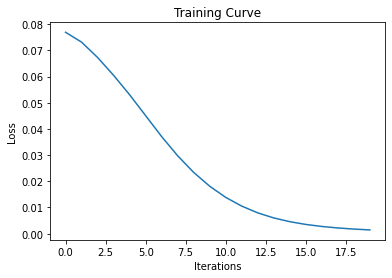

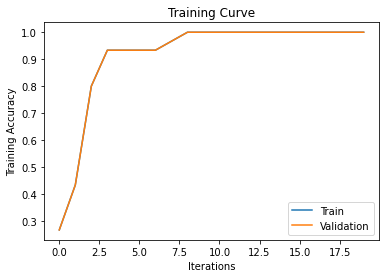

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
#Testing if I can overfit with Alex Net
alexNetClassify = Waste_Classifier_ANN(name="Waste_AlexNet")
if use_cuda and torch.cuda.is_available():
  alexNetClassify = alexNetClassify.cuda()
train(alexNetClassify, feature_tiny_set, feature_tiny_set, batch_size=30, num_epochs=20, learning_rate=0.002)

Epoch 1: Train accuracy: 0.10965848452508005, Training Loss: 0.018743792548775673, Validation Accuracy: 0.10897435897435898
Epoch 2: Train accuracy: 0.10939167556029883, Training Loss: 0.01851542294025421, Validation Accuracy: 0.10897435897435898
Epoch 3: Train accuracy: 0.10885805763073639, Training Loss: 0.018370766192674637, Validation Accuracy: 0.12393162393162394
Epoch 4: Train accuracy: 0.08911419423692636, Training Loss: 0.01829303428530693, Validation Accuracy: 0.09188034188034189
Epoch 5: Train accuracy: 0.13660618996798293, Training Loss: 0.018264027312397957, Validation Accuracy: 0.1282051282051282
Epoch 6: Train accuracy: 0.17849519743863393, Training Loss: 0.017810843884944916, Validation Accuracy: 0.1581196581196581
Epoch 7: Train accuracy: 0.14300960512273211, Training Loss: 0.017581460997462273, Validation Accuracy: 0.13675213675213677
Epoch 8: Train accuracy: 0.14701173959445038, Training Loss: 0.01744789630174637, Validation Accuracy: 0.13675213675213677
Epoch 9: Trai

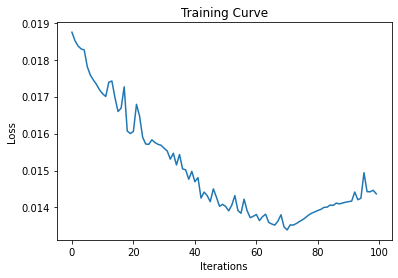

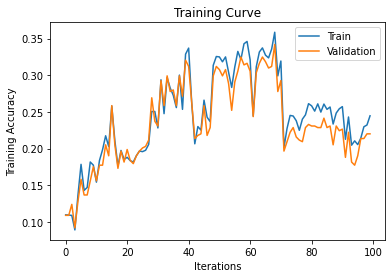

Final Training Accuracy: 0.24466382070437567
Final Validation Accuracy: 0.22008547008547008


In [ ]:
#Do Training with AlexNet
alexNetClassify = Waste_Classifier_ANN(name="Waste_AlexNet")
if use_cuda and torch.cuda.is_available():
  alexNetClassify = alexNetClassify.cuda()
train(alexNetClassify, feature_train_set, feature_val_set, batch_size=128, num_epochs=100, learning_rate=0.002)

alexnet learning rate: 0.003, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.10885805763073639, Training Loss: 0.009209912270307541, Validation Accuracy: 0.10256410256410256
Epoch 11: Train accuracy: 0.31163287086446106, Training Loss: 0.007375020068138838, Validation Accuracy: 0.3141025641025641
Epoch 21: Train accuracy: 0.5066702241195304, Training Loss: 0.006651753559708595, Validation Accuracy: 0.47435897435897434
Epoch 31: Train accuracy: 0.597385272145144, Training Loss: 0.004529265221208334, Validation Accuracy: 0.5256410256410257
Epoch 41: Train accuracy: 0.5096051227321238, Training Loss: 0.006371924187988043, Validation Accuracy: 0.4807692307692308
Epoch 51: Train accuracy: 0.5957844183564568, Training Loss: 0.005241815000772476, Validation Accuracy: 0.5534188034188035
Epoch 61: Train accuracy: 0.47011739594450375, Training Loss: 0.004547027871012688, Validation Accuracy: 0.4337606837606838
Epoch 71: Train accuracy: 0.5117395944503735, Training Loss: 0.0062361592

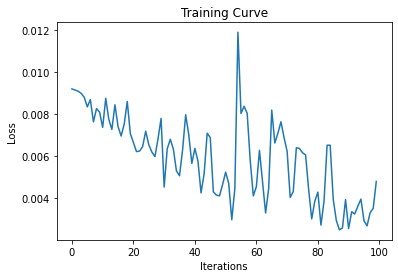

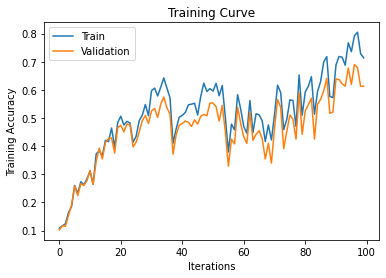

Final Training Accuracy: 0.7139807897545357
Final Validation Accuracy: 0.6132478632478633
alexnet learning rate: 0.001, batchsize: 128
cude is available
Epoch 1: Train accuracy: 0.15875133404482392, Training Loss: 0.019172247499227524, Validation Accuracy: 0.18376068376068377
Epoch 11: Train accuracy: 0.24413020277481323, Training Loss: 0.014436725527048111, Validation Accuracy: 0.24145299145299146
Epoch 21: Train accuracy: 0.28121664887940234, Training Loss: 0.01802843064069748, Validation Accuracy: 0.27564102564102566
Epoch 31: Train accuracy: 0.4645144076840982, Training Loss: 0.010941319167613983, Validation Accuracy: 0.4465811965811966
Epoch 41: Train accuracy: 0.4781216648879402, Training Loss: 0.004328036680817604, Validation Accuracy: 0.46794871794871795
Epoch 51: Train accuracy: 0.6531483457844184, Training Loss: 0.004232171457260847, Validation Accuracy: 0.6367521367521367
Epoch 61: Train accuracy: 0.5816435432230523, Training Loss: 0.004100595600903034, Validation Accuracy: 

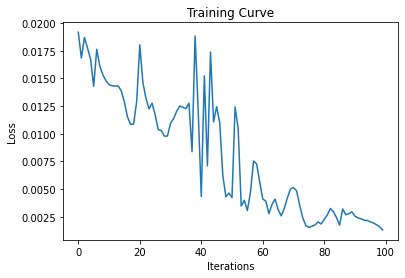

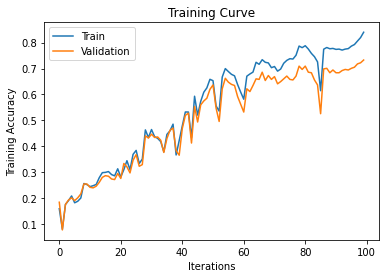

Final Training Accuracy: 0.8401814300960512
Final Validation Accuracy: 0.7329059829059829
alexnet learning rate: 0.001, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.1811632870864461, Training Loss: 0.010326392948627472, Validation Accuracy: 0.16666666666666666
Epoch 11: Train accuracy: 0.6520811099252934, Training Loss: 0.0050576236099004745, Validation Accuracy: 0.655982905982906
Epoch 21: Train accuracy: 0.7977588046958378, Training Loss: 0.002726561389863491, Validation Accuracy: 0.7606837606837606
Epoch 31: Train accuracy: 0.8644610458911419, Training Loss: 0.0018490187358111143, Validation Accuracy: 0.7884615384615384
Epoch 41: Train accuracy: 0.9058164354322306, Training Loss: 0.0013618392404168844, Validation Accuracy: 0.8076923076923077
Epoch 51: Train accuracy: 0.9311632870864461, Training Loss: 0.0010483931982889771, Validation Accuracy: 0.8162393162393162
Epoch 61: Train accuracy: 0.9503735325506937, Training Loss: 0.0008404491236433387, Validation Accuracy: 0

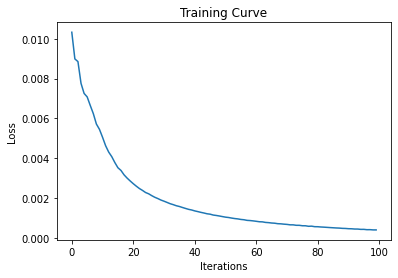

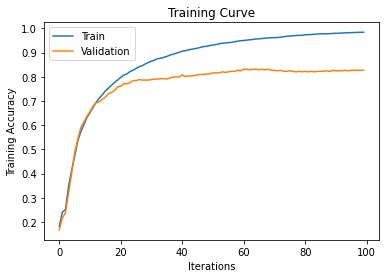

Final Training Accuracy: 0.9842582710779082
Final Validation Accuracy: 0.8269230769230769
alexnet learning rate: 0.0005, batchsize: 64
cude is available
Epoch 1: Train accuracy: 0.13073639274279616, Training Loss: 0.037466634064912796, Validation Accuracy: 0.1517094017094017
Epoch 11: Train accuracy: 0.2673425827107791, Training Loss: 0.03085513971745968, Validation Accuracy: 0.25854700854700857
Epoch 21: Train accuracy: 0.4050160085378869, Training Loss: 0.02202371135354042, Validation Accuracy: 0.3888888888888889
Epoch 31: Train accuracy: 0.5589647812166488, Training Loss: 0.024975501000881195, Validation Accuracy: 0.5363247863247863
Epoch 41: Train accuracy: 0.6723585912486659, Training Loss: 0.016515009105205536, Validation Accuracy: 0.6495726495726496
Epoch 51: Train accuracy: 0.7323906083244397, Training Loss: 0.010002773255109787, Validation Accuracy: 0.6688034188034188
Epoch 61: Train accuracy: 0.7011739594450374, Training Loss: 0.005029165185987949, Validation Accuracy: 0.6260

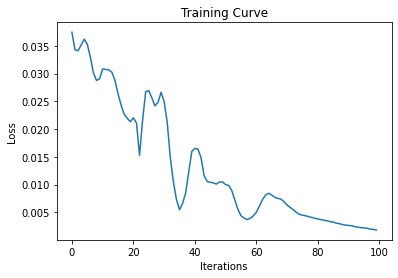

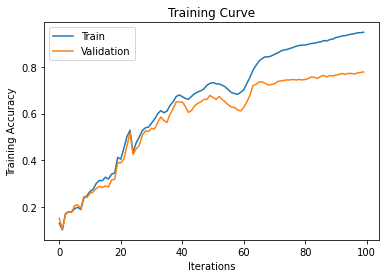

Final Training Accuracy: 0.9474386339381003
Final Validation Accuracy: 0.7777777777777778
alexnet learning rate: 0.0005, batchsize: 128
cude is available
Epoch 1: Train accuracy: 0.1715581643543223, Training Loss: 0.01968570053577423, Validation Accuracy: 0.1623931623931624
Epoch 11: Train accuracy: 0.5570971184631803, Training Loss: 0.012170976027846336, Validation Accuracy: 0.5512820512820513
Epoch 21: Train accuracy: 0.7251867662753468, Training Loss: 0.007098090369254351, Validation Accuracy: 0.6837606837606838
Epoch 31: Train accuracy: 0.8076307363927427, Training Loss: 0.0040560755878686905, Validation Accuracy: 0.7478632478632479
Epoch 41: Train accuracy: 0.865795090715048, Training Loss: 0.002436071401461959, Validation Accuracy: 0.7735042735042735
Epoch 51: Train accuracy: 0.8975453575240128, Training Loss: 0.0016684476286172867, Validation Accuracy: 0.7905982905982906
Epoch 61: Train accuracy: 0.9258271077908218, Training Loss: 0.001252049463801086, Validation Accuracy: 0.809

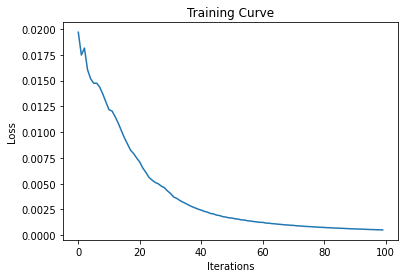

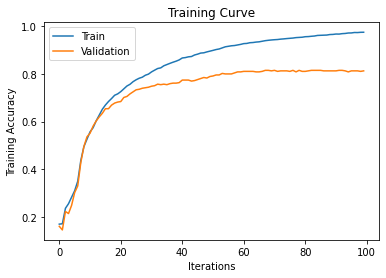

Final Training Accuracy: 0.9733191035218783
Final Validation Accuracy: 0.811965811965812
alexnet learning rate: 0.0005, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.24146211312700105, Training Loss: 0.010209707543253899, Validation Accuracy: 0.21794871794871795
Epoch 11: Train accuracy: 0.6953041622198506, Training Loss: 0.004450885578989983, Validation Accuracy: 0.6965811965811965
Epoch 21: Train accuracy: 0.7958911419423693, Training Loss: 0.0027804295532405376, Validation Accuracy: 0.7628205128205128
Epoch 31: Train accuracy: 0.8455176093916755, Training Loss: 0.002049739472568035, Validation Accuracy: 0.7777777777777778
Epoch 41: Train accuracy: 0.8708644610458911, Training Loss: 0.0016405662754550576, Validation Accuracy: 0.7948717948717948
Epoch 51: Train accuracy: 0.8991462113127001, Training Loss: 0.001374965300783515, Validation Accuracy: 0.8141025641025641
Epoch 61: Train accuracy: 0.9218249733191035, Training Loss: 0.0011763578513637185, Validation Accuracy: 0

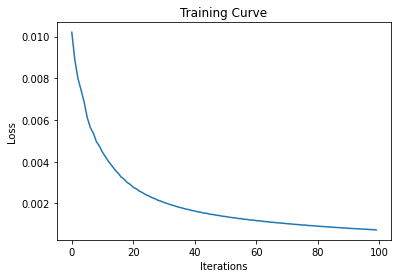

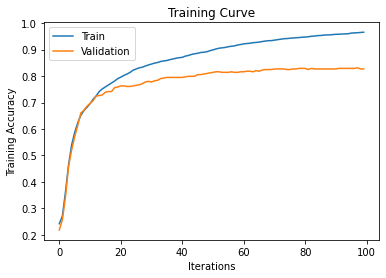

Final Training Accuracy: 0.9658484525080042
Final Validation Accuracy: 0.8269230769230769


In [ ]:
lr_bs=[[.003,256],[.001,128],[.001,256],[.0005,64],[.0005,128],[.0005,256]]
for lrbs in lr_bs:
    print("alexnet learning rate: {}, batchsize: {}".format(lrbs[0],lrbs[1]))
    alexNetClassify = Waste_Classifier_ANN(name="Waste_AlexNetMLP_CNN_"+str(lrbs[0])+"_"+str(lrbs[1]))
    if use_cuda and torch.cuda.is_available():
      print("cude is available")
      alexNetClassify = alexNetClassify.cuda()
    train(alexNetClassify, feature_train_set, feature_val_set, batch_size=lrbs[1], num_epochs=100, learning_rate=lrbs[0])

In [ ]:
val_set = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, num_workers=1)
for i in range(10):

  print("class A:",get_accuracy_of_label(alexNetClassify, val_loader, i))
print("class B:",get_accuracy_of_label(alexNetClassify, val_loader, 1))
print("class C:",get_accuracy_of_label(alexNetClassify, val_loader, 3))
print("class D:",get_accuracy_of_label(alexNetClassify, val_loader, 4))
print("class E:",get_accuracy_of_label(alexNetClassify, val_loader, 5))
# train_loader = torch.utils.data.DataLoader([e for e in train_set if train_set.labels==1], batch_size=64, num_workers=1)

class A: 0.84375
class B: 0.71875
class C: 0.859375
class D: 0.8125
class E: 0.90625


Epoch 1: Train accuracy: 0.1376734258271078, Training Loss: 0.018297206610441208, Validation Accuracy: 0.14102564102564102
Epoch 2: Train accuracy: 0.05496264674493063, Training Loss: 0.018605642020702362, Validation Accuracy: 0.04487179487179487
Epoch 3: Train accuracy: 0.1376734258271078, Training Loss: 0.018509071320295334, Validation Accuracy: 0.14102564102564102
Epoch 4: Train accuracy: 0.217982924226254, Training Loss: 0.018029946833848953, Validation Accuracy: 0.2222222222222222
Epoch 5: Train accuracy: 0.1923692636072572, Training Loss: 0.01765989512205124, Validation Accuracy: 0.19658119658119658
Epoch 6: Train accuracy: 0.21211312700106724, Training Loss: 0.0174824558198452, Validation Accuracy: 0.1987179487179487
Epoch 7: Train accuracy: 0.2929562433297759, Training Loss: 0.017423495650291443, Validation Accuracy: 0.3141025641025641
Epoch 8: Train accuracy: 0.35965848452508004, Training Loss: 0.01714729517698288, Validation Accuracy: 0.35683760683760685
Epoch 9: Train accura

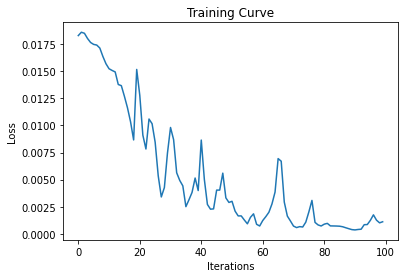

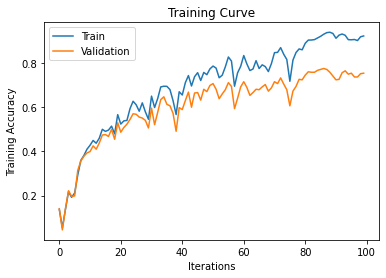

Final Training Accuracy: 0.9228922091782283
Final Validation Accuracy: 0.7542735042735043


In [ ]:
alexNetClassify = Waste_Classifier_MLP(name="Waste_AlexNetMLP")
if use_cuda and torch.cuda.is_available():
  alexNetClassify = alexNetClassify.cuda()
train(alexNetClassify, feature_train_set, feature_val_set, batch_size=128, num_epochs=100, learning_rate=0.002)

alexnet learning rate: 0.005, batchsize: 32
cude is available
Epoch 1: Train accuracy: 0.10538954108858058, Training Loss: 0.07583829760551453, Validation Accuracy: 0.1047008547008547
Epoch 11: Train accuracy: 0.15848452508004268, Training Loss: 0.06836025416851044, Validation Accuracy: 0.14743589743589744
Epoch 21: Train accuracy: 0.10538954108858058, Training Loss: 0.0683961734175682, Validation Accuracy: 0.1047008547008547
Epoch 31: Train accuracy: 0.10538954108858058, Training Loss: 0.0683961734175682, Validation Accuracy: 0.1047008547008547
Epoch 41: Train accuracy: 0.10538954108858058, Training Loss: 0.0683961734175682, Validation Accuracy: 0.1047008547008547
Epoch 51: Train accuracy: 0.10538954108858058, Training Loss: 0.0683961734175682, Validation Accuracy: 0.1047008547008547
Epoch 61: Train accuracy: 0.10538954108858058, Training Loss: 0.0683961734175682, Validation Accuracy: 0.1047008547008547
Epoch 71: Train accuracy: 0.10538954108858058, Training Loss: 0.0683961734175682, 

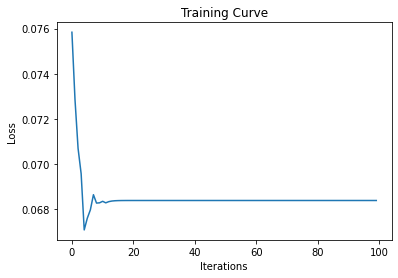

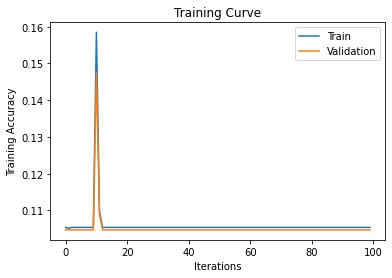

Final Training Accuracy: 0.10538954108858058
Final Validation Accuracy: 0.1047008547008547
alexnet learning rate: 0.005, batchsize: 64
cude is available
Epoch 1: Train accuracy: 0.10859124866595518, Training Loss: 0.037236537784338, Validation Accuracy: 0.10897435897435898
Epoch 11: Train accuracy: 0.10992529348986126, Training Loss: 0.034725017845630646, Validation Accuracy: 0.10897435897435898
Epoch 21: Train accuracy: 0.12966915688367128, Training Loss: 0.03483998030424118, Validation Accuracy: 0.12606837606837606
Epoch 31: Train accuracy: 0.1328708644610459, Training Loss: 0.03441192954778671, Validation Accuracy: 0.12606837606837606
Epoch 41: Train accuracy: 0.13500533617929564, Training Loss: 0.03429357707500458, Validation Accuracy: 0.1282051282051282
Epoch 51: Train accuracy: 0.12113127001067236, Training Loss: 0.03420800715684891, Validation Accuracy: 0.11324786324786325
Epoch 61: Train accuracy: 0.14487726787620064, Training Loss: 0.03417535126209259, Validation Accuracy: 0.1

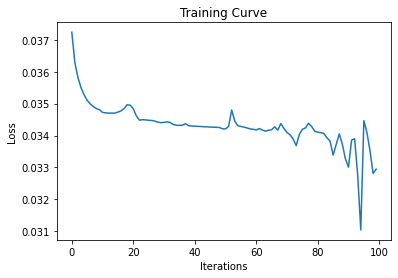

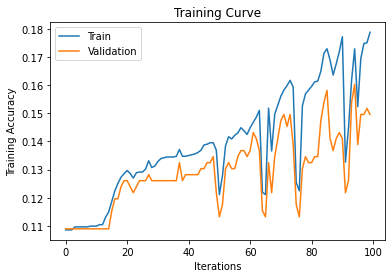

Final Training Accuracy: 0.17876200640341516
Final Validation Accuracy: 0.14957264957264957
alexnet learning rate: 0.005, batchsize: 128
cude is available
Epoch 1: Train accuracy: 0.10058697972251868, Training Loss: 0.01814110018312931, Validation Accuracy: 0.11752136752136752
Epoch 11: Train accuracy: 0.10779082177161152, Training Loss: 0.016373930498957634, Validation Accuracy: 0.10897435897435898
Epoch 21: Train accuracy: 0.10779082177161152, Training Loss: 0.014738922007381916, Validation Accuracy: 0.10897435897435898
Epoch 31: Train accuracy: 0.10779082177161152, Training Loss: 0.016285600140690804, Validation Accuracy: 0.10897435897435898
Epoch 41: Train accuracy: 0.18623265741728923, Training Loss: 0.01583945006132126, Validation Accuracy: 0.1858974358974359
Epoch 51: Train accuracy: 0.21398078975453574, Training Loss: 0.015605239197611809, Validation Accuracy: 0.21794871794871795
Epoch 61: Train accuracy: 0.22011739594450375, Training Loss: 0.015042237006127834, Validation Accu

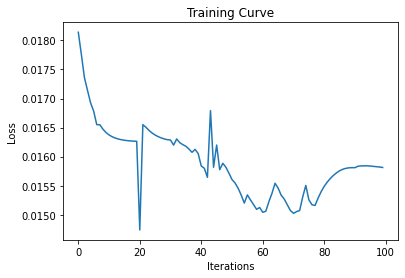

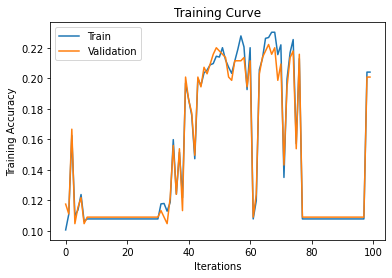

Final Training Accuracy: 0.20410885805763074
Final Validation Accuracy: 0.20085470085470086
alexnet learning rate: 0.005, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.10138740661686232, Training Loss: 0.011387553997337818, Validation Accuracy: 0.10042735042735043
Epoch 11: Train accuracy: 0.41275346851654215, Training Loss: 0.00808058399707079, Validation Accuracy: 0.38675213675213677
Epoch 21: Train accuracy: 0.5170757737459979, Training Loss: 0.007090535946190357, Validation Accuracy: 0.4722222222222222
Epoch 31: Train accuracy: 0.6310032017075774, Training Loss: 0.004942467901855707, Validation Accuracy: 0.6025641025641025
Epoch 41: Train accuracy: 0.807897545357524, Training Loss: 0.0035104507114738226, Validation Accuracy: 0.7286324786324786
Epoch 51: Train accuracy: 0.878068303094984, Training Loss: 0.0010363617911934853, Validation Accuracy: 0.7628205128205128
Epoch 61: Train accuracy: 0.6630202774813234, Training Loss: 0.005415405612438917, Validation Accuracy: 0

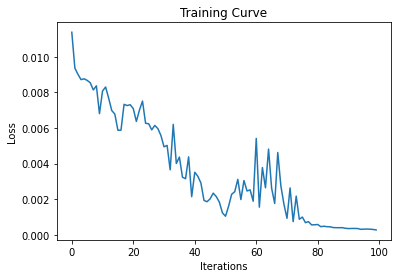

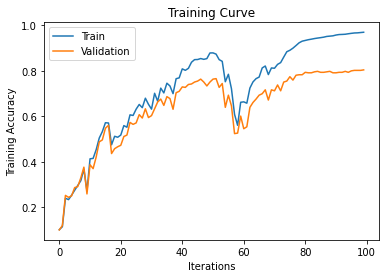

Final Training Accuracy: 0.9687833511205977
Final Validation Accuracy: 0.8034188034188035
alexnet learning rate: 0.003, batchsize: 32
cude is available
Epoch 1: Train accuracy: 0.10965848452508005, Training Loss: 0.07253502309322357, Validation Accuracy: 0.10897435897435898
Epoch 11: Train accuracy: 0.10779082177161152, Training Loss: 0.06820835918188095, Validation Accuracy: 0.10683760683760683
Epoch 21: Train accuracy: 0.10965848452508005, Training Loss: 0.06816370785236359, Validation Accuracy: 0.10897435897435898
Epoch 31: Train accuracy: 0.10965848452508005, Training Loss: 0.0681525394320488, Validation Accuracy: 0.10897435897435898
Epoch 41: Train accuracy: 0.10965848452508005, Training Loss: 0.068203404545784, Validation Accuracy: 0.10897435897435898
Epoch 51: Train accuracy: 0.10965848452508005, Training Loss: 0.06820394843816757, Validation Accuracy: 0.10897435897435898
Epoch 61: Train accuracy: 0.10965848452508005, Training Loss: 0.06820392608642578, Validation Accuracy: 0.10

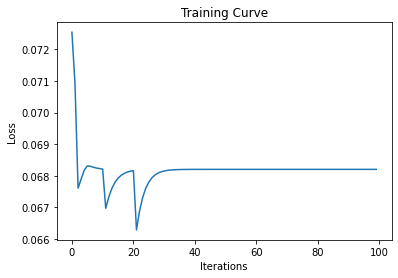

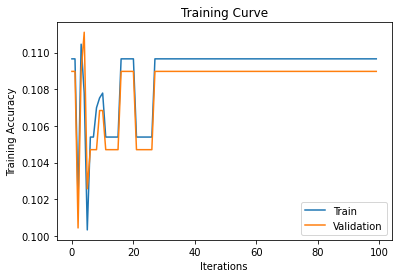

Final Training Accuracy: 0.10965848452508005
Final Validation Accuracy: 0.10897435897435898
alexnet learning rate: 0.003, batchsize: 64
cude is available
Epoch 1: Train accuracy: 0.10192102454642477, Training Loss: 0.03569846227765083, Validation Accuracy: 0.10256410256410256
Epoch 11: Train accuracy: 0.10779082177161152, Training Loss: 0.0342736691236496, Validation Accuracy: 0.10897435897435898
Epoch 21: Train accuracy: 0.17662753468516543, Training Loss: 0.03382705897092819, Validation Accuracy: 0.17735042735042736
Epoch 31: Train accuracy: 0.14327641408751335, Training Loss: 0.03352948650717735, Validation Accuracy: 0.1346153846153846
Epoch 41: Train accuracy: 0.10965848452508005, Training Loss: 0.03399084880948067, Validation Accuracy: 0.10897435897435898
Epoch 51: Train accuracy: 0.10965848452508005, Training Loss: 0.034268368035554886, Validation Accuracy: 0.10897435897435898
Epoch 61: Train accuracy: 0.10965848452508005, Training Loss: 0.03433440998196602, Validation Accuracy: 

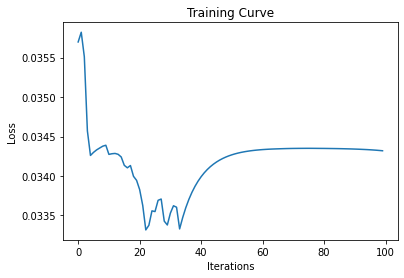

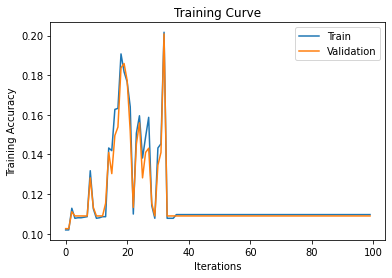

Final Training Accuracy: 0.10965848452508005
Final Validation Accuracy: 0.10897435897435898
alexnet learning rate: 0.003, batchsize: 128
cude is available
Epoch 1: Train accuracy: 0.10138740661686232, Training Loss: 0.018057864159345627, Validation Accuracy: 0.10042735042735043
Epoch 11: Train accuracy: 0.2833511205976521, Training Loss: 0.0162343792617321, Validation Accuracy: 0.2670940170940171
Epoch 21: Train accuracy: 0.2692102454642476, Training Loss: 0.013825329020619392, Validation Accuracy: 0.27350427350427353
Epoch 31: Train accuracy: 0.5434898612593383, Training Loss: 0.010330040007829666, Validation Accuracy: 0.5149572649572649
Epoch 41: Train accuracy: 0.5557630736392742, Training Loss: 0.010906603187322617, Validation Accuracy: 0.5149572649572649
Epoch 51: Train accuracy: 0.6520811099252934, Training Loss: 0.009198937565088272, Validation Accuracy: 0.5982905982905983
Epoch 61: Train accuracy: 0.5301494130202775, Training Loss: 0.010303733870387077, Validation Accuracy: 0.5

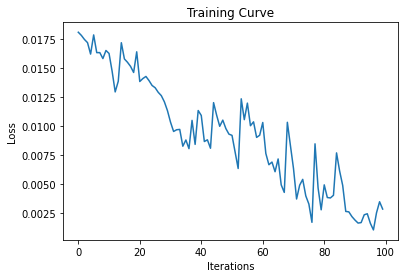

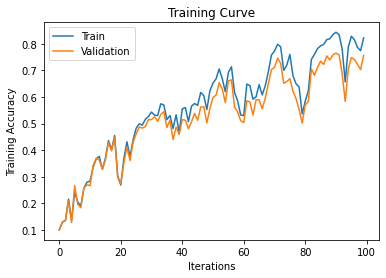

Final Training Accuracy: 0.8223052294557097
Final Validation Accuracy: 0.7564102564102564
alexnet learning rate: 0.003, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.13260405549626467, Training Loss: 0.010511385276913643, Validation Accuracy: 0.14316239316239315
Epoch 11: Train accuracy: 0.62940234791889, Training Loss: 0.005111257545650005, Validation Accuracy: 0.6025641025641025
Epoch 21: Train accuracy: 0.7590715048025614, Training Loss: 0.002192719606682658, Validation Accuracy: 0.717948717948718
Epoch 31: Train accuracy: 0.8823372465314835, Training Loss: 0.001624037977308035, Validation Accuracy: 0.7841880341880342
Epoch 41: Train accuracy: 0.913820704375667, Training Loss: 0.0013192319311201572, Validation Accuracy: 0.782051282051282
Epoch 51: Train accuracy: 0.8519210245464247, Training Loss: 0.0012003184529021382, Validation Accuracy: 0.7243589743589743
Epoch 61: Train accuracy: 0.9690501600853789, Training Loss: 0.00044753303518518806, Validation Accuracy: 0.816

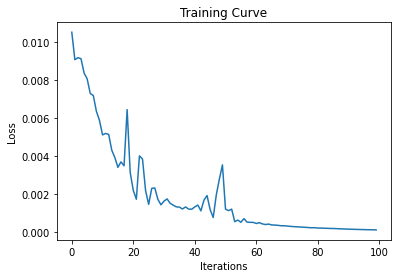

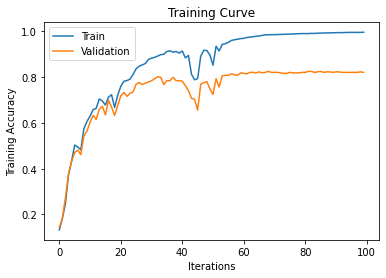

Final Training Accuracy: 0.9957310565635006
Final Validation Accuracy: 0.8205128205128205
alexnet learning rate: 0.001, batchsize: 32
cude is available
Epoch 1: Train accuracy: 0.11819637139807898, Training Loss: 0.0711205005645752, Validation Accuracy: 0.10256410256410256
Epoch 11: Train accuracy: 0.17742796157950907, Training Loss: 0.0615570992231369, Validation Accuracy: 0.16452991452991453
Epoch 21: Train accuracy: 0.1552828175026681, Training Loss: 0.027855953201651573, Validation Accuracy: 0.14957264957264957
Epoch 31: Train accuracy: 0.19743863393810032, Training Loss: 0.008492514491081238, Validation Accuracy: 0.19444444444444445
Epoch 41: Train accuracy: 0.23505869797225187, Training Loss: 0.004764691460877657, Validation Accuracy: 0.22435897435897437
Epoch 51: Train accuracy: 0.2892209178228389, Training Loss: 0.009115282446146011, Validation Accuracy: 0.28205128205128205
Epoch 61: Train accuracy: 0.31643543223052295, Training Loss: 0.010364417918026447, Validation Accuracy: 

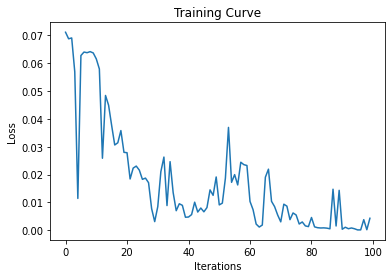

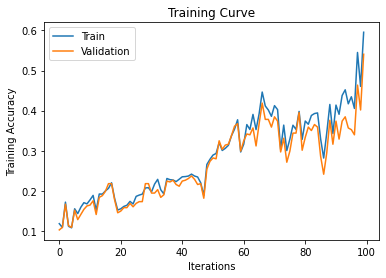

Final Training Accuracy: 0.5955176093916755
Final Validation Accuracy: 0.5405982905982906
alexnet learning rate: 0.001, batchsize: 64
cude is available
Epoch 1: Train accuracy: 0.11712913553895411, Training Loss: 0.03605714067816734, Validation Accuracy: 0.11538461538461539
Epoch 11: Train accuracy: 0.37406616862326575, Training Loss: 0.029542608186602592, Validation Accuracy: 0.36752136752136755
Epoch 21: Train accuracy: 0.5888473852721452, Training Loss: 0.019452355802059174, Validation Accuracy: 0.5576923076923077
Epoch 31: Train accuracy: 0.5971184631803629, Training Loss: 0.02087225578725338, Validation Accuracy: 0.5534188034188035
Epoch 41: Train accuracy: 0.7022411953041622, Training Loss: 0.01345179881900549, Validation Accuracy: 0.6346153846153846
Epoch 51: Train accuracy: 0.7185165421558164, Training Loss: 0.0162238497287035, Validation Accuracy: 0.6217948717948718
Epoch 61: Train accuracy: 0.8009605122732124, Training Loss: 0.006834110710769892, Validation Accuracy: 0.688034

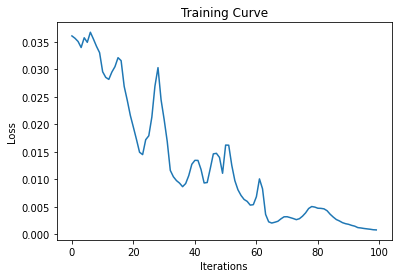

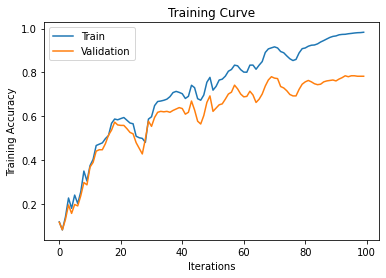

Final Training Accuracy: 0.9829242262540021
Final Validation Accuracy: 0.782051282051282
alexnet learning rate: 0.001, batchsize: 128
cude is available
Epoch 1: Train accuracy: 0.1315368196371398, Training Loss: 0.01993001624941826, Validation Accuracy: 0.11752136752136752
Epoch 11: Train accuracy: 0.6013874066168623, Training Loss: 0.011429949663579464, Validation Accuracy: 0.5811965811965812
Epoch 21: Train accuracy: 0.7030416221985059, Training Loss: 0.007763451896607876, Validation Accuracy: 0.6645299145299145
Epoch 31: Train accuracy: 0.8297758804695837, Training Loss: 0.002685488434508443, Validation Accuracy: 0.7585470085470085
Epoch 41: Train accuracy: 0.8874066168623266, Training Loss: 0.0013381601311266422, Validation Accuracy: 0.7863247863247863
Epoch 51: Train accuracy: 0.82017075773746, Training Loss: 0.0014264556812122464, Validation Accuracy: 0.7051282051282052
Epoch 61: Train accuracy: 0.9493062966915689, Training Loss: 0.000629149260930717, Validation Accuracy: 0.81623

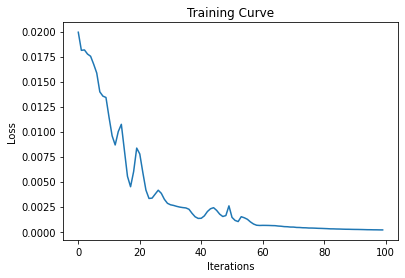

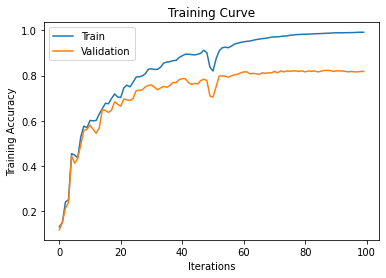

Final Training Accuracy: 0.991462113127001
Final Validation Accuracy: 0.8183760683760684
alexnet learning rate: 0.001, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.17689434364994663, Training Loss: 0.00952143408358097, Validation Accuracy: 0.16880341880341881
Epoch 11: Train accuracy: 0.6472785485592316, Training Loss: 0.005488129798322916, Validation Accuracy: 0.6196581196581197
Epoch 21: Train accuracy: 0.7769477054429029, Training Loss: 0.0030861336272209883, Validation Accuracy: 0.7414529914529915
Epoch 31: Train accuracy: 0.8444503735325507, Training Loss: 0.002056089462712407, Validation Accuracy: 0.7735042735042735
Epoch 41: Train accuracy: 0.8892742796157951, Training Loss: 0.0014965105801820755, Validation Accuracy: 0.7863247863247863
Epoch 51: Train accuracy: 0.9244930629669157, Training Loss: 0.0011354107409715652, Validation Accuracy: 0.7948717948717948
Epoch 61: Train accuracy: 0.9493062966915689, Training Loss: 0.0008879171218723059, Validation Accuracy: 0.

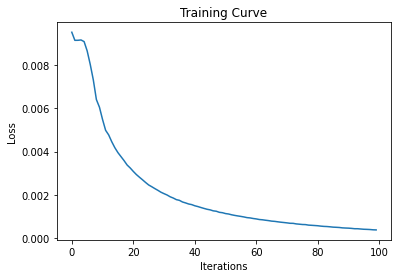

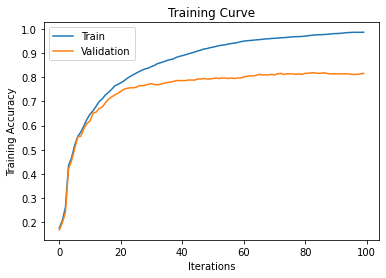

Final Training Accuracy: 0.9861259338313767
Final Validation Accuracy: 0.8162393162393162
alexnet learning rate: 0.0005, batchsize: 32
cude is available
Epoch 1: Train accuracy: 0.11926360725720384, Training Loss: 0.07078307867050171, Validation Accuracy: 0.13034188034188035
Epoch 11: Train accuracy: 0.31670224119530416, Training Loss: 0.05396021530032158, Validation Accuracy: 0.30982905982905984
Epoch 21: Train accuracy: 0.5053361792956244, Training Loss: 0.008692163974046707, Validation Accuracy: 0.47863247863247865
Epoch 31: Train accuracy: 0.4973319103521878, Training Loss: 0.003544819774106145, Validation Accuracy: 0.4700854700854701
Epoch 41: Train accuracy: 0.6942369263607258, Training Loss: 0.011164371855556965, Validation Accuracy: 0.5982905982905983
Epoch 51: Train accuracy: 0.7006403415154749, Training Loss: 0.004794280510395765, Validation Accuracy: 0.6111111111111112
Epoch 61: Train accuracy: 0.7766808964781217, Training Loss: 0.0017241897294297814, Validation Accuracy: 0.

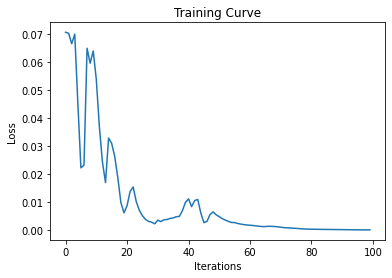

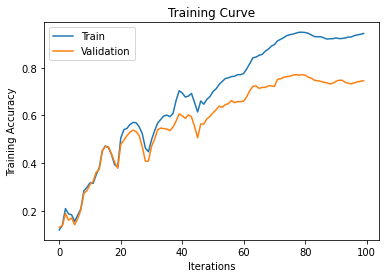

Final Training Accuracy: 0.9445037353255069
Final Validation Accuracy: 0.7457264957264957
alexnet learning rate: 0.0005, batchsize: 64
cude is available
Epoch 1: Train accuracy: 0.18009605122732122, Training Loss: 0.036739885807037354, Validation Accuracy: 0.14743589743589744
Epoch 11: Train accuracy: 0.5261472785485592, Training Loss: 0.03302746266126633, Validation Accuracy: 0.49572649572649574
Epoch 21: Train accuracy: 0.6763607257203842, Training Loss: 0.021763693541288376, Validation Accuracy: 0.6367521367521367
Epoch 31: Train accuracy: 0.7969583778014941, Training Loss: 0.009691246785223484, Validation Accuracy: 0.7329059829059829
Epoch 41: Train accuracy: 0.7956243329775881, Training Loss: 0.00897977128624916, Validation Accuracy: 0.6944444444444444
Epoch 51: Train accuracy: 0.8954108858057631, Training Loss: 0.005655235145241022, Validation Accuracy: 0.7585470085470085
Epoch 61: Train accuracy: 0.9375667022411953, Training Loss: 0.003423681017011404, Validation Accuracy: 0.794

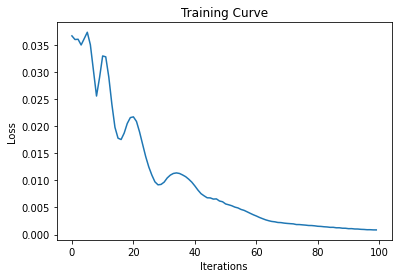

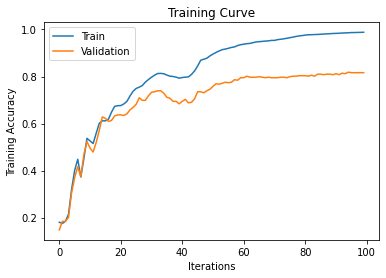

Final Training Accuracy: 0.9882604055496265
Final Validation Accuracy: 0.8162393162393162
alexnet learning rate: 0.0005, batchsize: 128
cude is available
Epoch 1: Train accuracy: 0.15741728922091783, Training Loss: 0.019140388816595078, Validation Accuracy: 0.1452991452991453
Epoch 11: Train accuracy: 0.6008537886872999, Training Loss: 0.011755045503377914, Validation Accuracy: 0.5790598290598291
Epoch 21: Train accuracy: 0.7398612593383138, Training Loss: 0.006050404626876116, Validation Accuracy: 0.6965811965811965
Epoch 31: Train accuracy: 0.8068303094983992, Training Loss: 0.003755382029339671, Validation Accuracy: 0.7457264957264957
Epoch 41: Train accuracy: 0.8633938100320171, Training Loss: 0.0025999308563768864, Validation Accuracy: 0.7713675213675214
Epoch 51: Train accuracy: 0.9002134471718249, Training Loss: 0.0018637398025020957, Validation Accuracy: 0.7927350427350427
Epoch 61: Train accuracy: 0.9258271077908218, Training Loss: 0.0013498389162123203, Validation Accuracy: 0

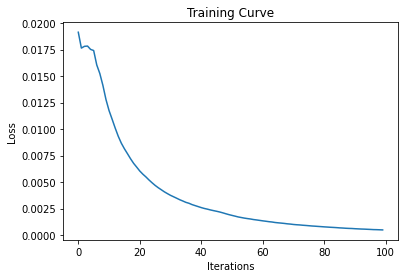

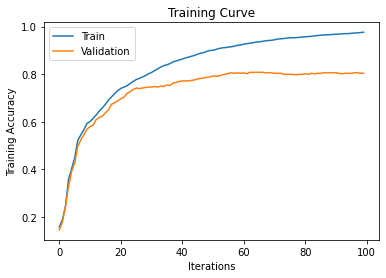

Final Training Accuracy: 0.9759871931696905
Final Validation Accuracy: 0.8034188034188035
alexnet learning rate: 0.0005, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.11125933831376734, Training Loss: 0.009131680242717266, Validation Accuracy: 0.11324786324786325
Epoch 11: Train accuracy: 0.5987193169690501, Training Loss: 0.00635515758767724, Validation Accuracy: 0.5854700854700855
Epoch 21: Train accuracy: 0.7078441835645678, Training Loss: 0.0037528355605900288, Validation Accuracy: 0.6901709401709402
Epoch 31: Train accuracy: 0.7740128068303095, Training Loss: 0.0026665322948247194, Validation Accuracy: 0.7329059829059829
Epoch 41: Train accuracy: 0.8207043756670224, Training Loss: 0.0020637742709368467, Validation Accuracy: 0.7799145299145299
Epoch 51: Train accuracy: 0.8489861259338314, Training Loss: 0.0016864367062225938, Validation Accuracy: 0.782051282051282
Epoch 61: Train accuracy: 0.8754002134471718, Training Loss: 0.0014241127064451575, Validation Accuracy: 

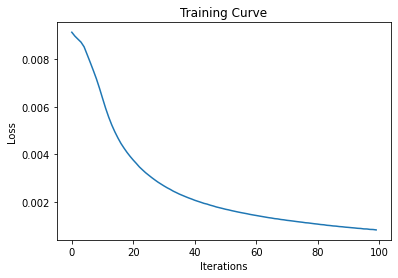

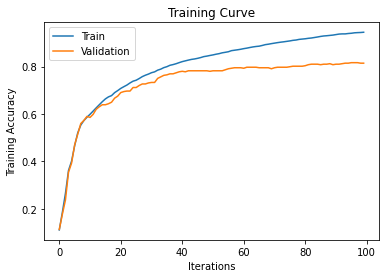

Final Training Accuracy: 0.9445037353255069
Final Validation Accuracy: 0.8141025641025641


In [ ]:
learning_rate=[.005,.003,.001,.0005]
batch_size=[32,64,128,256]
for lr in learning_rate:
  for bs in batch_size:
    print("alexnet learning rate: {}, batchsize: {}".format(lr,bs))
    alexNetClassify = Waste_Classifier_MLP(name="Waste_AlexNetMLP_"+str(lr)+"_"+str(bs))
    if use_cuda and torch.cuda.is_available():
      print("cude is available")
      alexNetClassify = alexNetClassify.cuda()
    train(alexNetClassify, feature_train_set, feature_val_set, batch_size=bs, num_epochs=100, learning_rate=lr)

Best combinations:

.0005, 256  
Best Training Accuracy: 0.9445037353255069 at epoch 99  
Best Validation Accuracy: 0.8162393162393162 at epoch 95  
.0005, 128  
Best Training Accuracy: 0.9759871931696905 at epoch 99  
Best Validation Accuracy: 0.8076923076923077 at epoch 62  

.0005,  
Best Training Accuracy: 0.9882604055496265 at epoch 99  
Best Validation Accuracy: 0.8183760683760684 at epoch 94  

.001, 256  
Best Training Accuracy: 0.9861259338313767 at epoch 99  
Best Validation Accuracy: 0.8183760683760684 at epoch 82  
.001, 128  
Best Training Accuracy: 0.991462113127001 at epoch 98  
Best Validation Accuracy: 0.8226495726495726 at epoch 86  
.003, 256  
Best Training Accuracy: 0.9957310565635006 at epoch 99  
Best Validation Accuracy: 0.8247863247863247 at epoch 68  



alexnet learning rate: 0.003, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.10352187833511206, Training Loss: 0.009777395986020565, Validation Accuracy: 0.1111111111111111
Epoch 11: Train accuracy: 0.5112059765208111, Training Loss: 0.00772415567189455, Validation Accuracy: 0.47863247863247865
Epoch 21: Train accuracy: 0.6470117395944504, Training Loss: 0.004954309668391943, Validation Accuracy: 0.5918803418803419
Epoch 31: Train accuracy: 0.7497331910352187, Training Loss: 0.002517265733331442, Validation Accuracy: 0.6794871794871795
Epoch 41: Train accuracy: 0.8217716115261473, Training Loss: 0.00245446665212512, Validation Accuracy: 0.7393162393162394
Epoch 51: Train accuracy: 0.8492529348986126, Training Loss: 0.002185605000704527, Validation Accuracy: 0.7756410256410257
Epoch 61: Train accuracy: 0.9218249733191035, Training Loss: 0.0011436305940151215, Validation Accuracy: 0.7884615384615384
Epoch 71: Train accuracy: 0.9348986125933831, Training Loss: 0.0007892550202

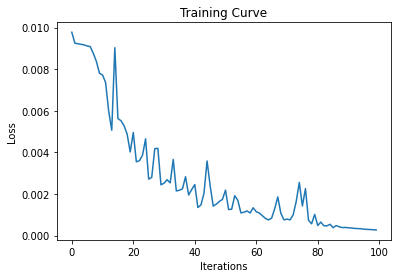

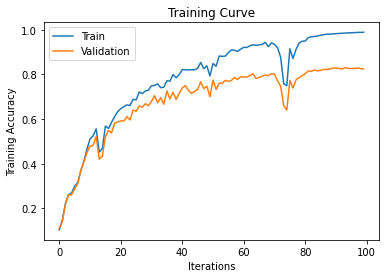

Final Training Accuracy: 0.9893276414087513
Final Validation Accuracy: 0.8247863247863247
alexnet learning rate: 0.001, batchsize: 128
cude is available
Epoch 1: Train accuracy: 0.1635538954108858, Training Loss: 0.019013021141290665, Validation Accuracy: 0.14743589743589744
Epoch 11: Train accuracy: 0.3441835645677695, Training Loss: 0.01383974775671959, Validation Accuracy: 0.3247863247863248
Epoch 21: Train accuracy: 0.5093383137673426, Training Loss: 0.006595345214009285, Validation Accuracy: 0.4829059829059829
Epoch 31: Train accuracy: 0.6875667022411953, Training Loss: 0.007214573677629232, Validation Accuracy: 0.655982905982906
Epoch 41: Train accuracy: 0.7580042689434365, Training Loss: 0.004773931577801704, Validation Accuracy: 0.6965811965811965
Epoch 51: Train accuracy: 0.8121664887940235, Training Loss: 0.00350499851629138, Validation Accuracy: 0.7286324786324786
Epoch 61: Train accuracy: 0.8615261472785486, Training Loss: 0.002159680938348174, Validation Accuracy: 0.756410

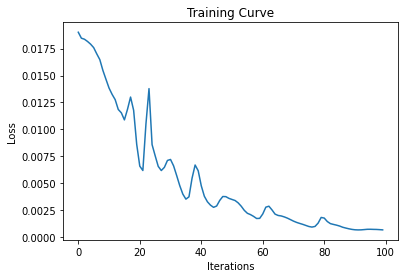

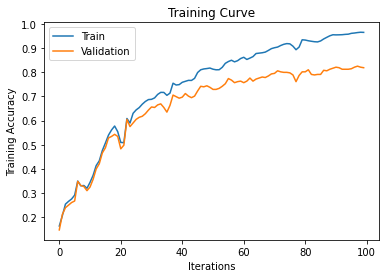

Final Training Accuracy: 0.9645144076840982
Final Validation Accuracy: 0.8183760683760684
alexnet learning rate: 0.001, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.1331376734258271, Training Loss: 0.009401144459843636, Validation Accuracy: 0.12393162393162394
Epoch 11: Train accuracy: 0.47491995731056563, Training Loss: 0.007574953138828278, Validation Accuracy: 0.4551282051282051
Epoch 21: Train accuracy: 0.6374066168623266, Training Loss: 0.00492419209331274, Validation Accuracy: 0.6175213675213675
Epoch 31: Train accuracy: 0.7238527214514408, Training Loss: 0.003419311949983239, Validation Accuracy: 0.7051282051282052
Epoch 41: Train accuracy: 0.7817502668089648, Training Loss: 0.002659730613231659, Validation Accuracy: 0.7435897435897436
Epoch 51: Train accuracy: 0.8132337246531484, Training Loss: 0.002220788039267063, Validation Accuracy: 0.7606837606837606
Epoch 61: Train accuracy: 0.844717182497332, Training Loss: 0.0019095278112217784, Validation Accuracy: 0.777

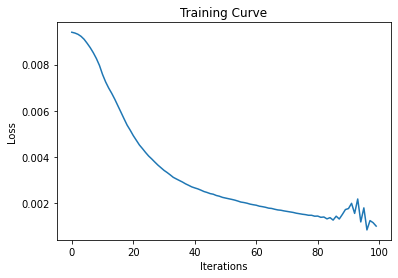

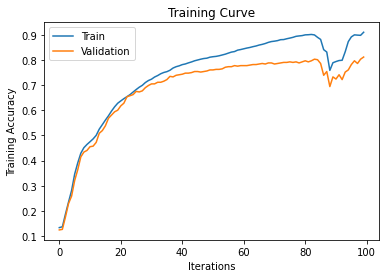

Final Training Accuracy: 0.9106189967982924
Final Validation Accuracy: 0.811965811965812
alexnet learning rate: 0.0005, batchsize: 64
cude is available
Epoch 1: Train accuracy: 0.13233724653148346, Training Loss: 0.03721127286553383, Validation Accuracy: 0.14743589743589744
Epoch 11: Train accuracy: 0.30389541088580574, Training Loss: 0.029599495232105255, Validation Accuracy: 0.3055555555555556
Epoch 21: Train accuracy: 0.5274813233724653, Training Loss: 0.025506604462862015, Validation Accuracy: 0.5277777777777778
Epoch 31: Train accuracy: 0.6451440768409819, Training Loss: 0.014648090116679668, Validation Accuracy: 0.5897435897435898
Epoch 41: Train accuracy: 0.7102454642475987, Training Loss: 0.012023835442960262, Validation Accuracy: 0.6303418803418803
Epoch 51: Train accuracy: 0.7750800426894343, Training Loss: 0.012864931486546993, Validation Accuracy: 0.6923076923076923
Epoch 61: Train accuracy: 0.8231056563500534, Training Loss: 0.008472123183310032, Validation Accuracy: 0.743

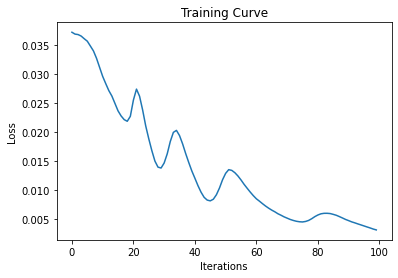

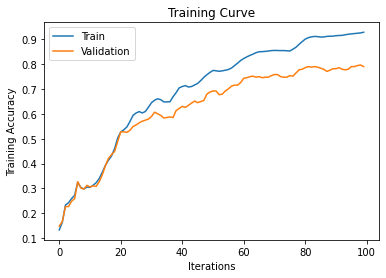

Final Training Accuracy: 0.9290288153681964
Final Validation Accuracy: 0.7905982905982906
alexnet learning rate: 0.0005, batchsize: 128
cude is available
Epoch 1: Train accuracy: 0.15154749199573106, Training Loss: 0.018876168876886368, Validation Accuracy: 0.1388888888888889
Epoch 11: Train accuracy: 0.42075773745997863, Training Loss: 0.01592898555099964, Validation Accuracy: 0.41239316239316237
Epoch 21: Train accuracy: 0.5872465314834578, Training Loss: 0.010140090249478817, Validation Accuracy: 0.5811965811965812
Epoch 31: Train accuracy: 0.6688900747065102, Training Loss: 0.006778462789952755, Validation Accuracy: 0.6431623931623932
Epoch 41: Train accuracy: 0.7337246531483458, Training Loss: 0.00483902869746089, Validation Accuracy: 0.6965811965811965
Epoch 51: Train accuracy: 0.7793489861259338, Training Loss: 0.003748896298930049, Validation Accuracy: 0.7286324786324786
Epoch 61: Train accuracy: 0.814034151547492, Training Loss: 0.0030869117472320795, Validation Accuracy: 0.75

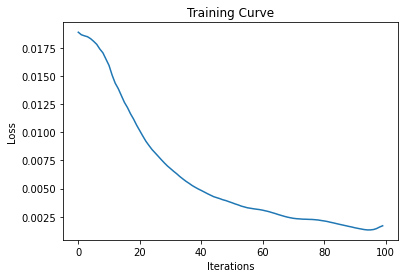

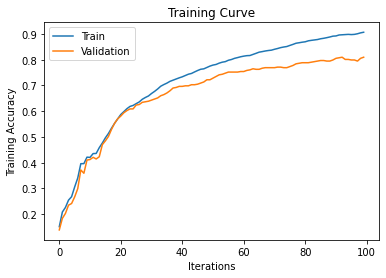

Final Training Accuracy: 0.9068836712913554
Final Validation Accuracy: 0.8098290598290598
alexnet learning rate: 0.0005, batchsize: 256
cude is available
Epoch 1: Train accuracy: 0.13127001067235858, Training Loss: 0.00922627653926611, Validation Accuracy: 0.12393162393162394
Epoch 11: Train accuracy: 0.4450373532550694, Training Loss: 0.008255756460130215, Validation Accuracy: 0.4230769230769231
Epoch 21: Train accuracy: 0.5528281750266809, Training Loss: 0.006208558566868305, Validation Accuracy: 0.5170940170940171
Epoch 31: Train accuracy: 0.6419423692636073, Training Loss: 0.004540889989584684, Validation Accuracy: 0.6132478632478633
Epoch 41: Train accuracy: 0.695837780149413, Training Loss: 0.003464339766651392, Validation Accuracy: 0.6923076923076923
Epoch 51: Train accuracy: 0.7454642475987193, Training Loss: 0.0028195662889629602, Validation Accuracy: 0.7222222222222222
Epoch 61: Train accuracy: 0.7772145144076841, Training Loss: 0.0024314643815159798, Validation Accuracy: 0.7

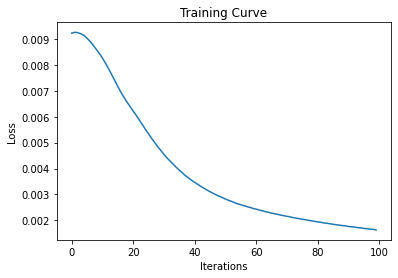

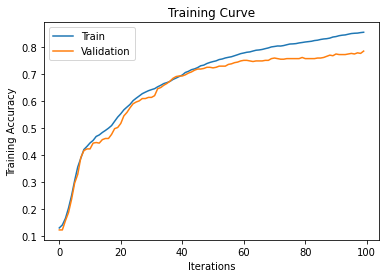

Final Training Accuracy: 0.8537886872998933
Final Validation Accuracy: 0.7841880341880342


In [ ]:
lr_bs=[[.003,256],[.001,128],[.001,256],[.0005,64],[.0005,128],[.0005,256]]
for lrbs in lr_bs:
    print("alexnet learning rate: {}, batchsize: {}".format(lrbs[0],lrbs[1]))
    alexNetClassify = Waste_Classifier_CNN(name="Waste_AlexNetMLP_CNN_"+str(lrbs[0])+"_"+str(lrbs[1]))
    if use_cuda and torch.cuda.is_available():
      print("cude is available")
      alexNetClassify = alexNetClassify.cuda()
    train(alexNetClassify, feature_train_set, feature_val_set, batch_size=lrbs[1], num_epochs=100, learning_rate=lrbs[0])

# Predictions and Testing --> ResNet18

Achieved Maximum of 94 % training and 89% validation accuracies without augmentation

In [ ]:
# Load the tensors
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transformations = transforms.Compose([                                     
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)  
])
train_set = torchvision.datasets.ImageFolder(train_path, transform = transformations)
val_set = torchvision.datasets.ImageFolder(val_path, transform = transformations)
test_set = torchvision.datasets.ImageFolder(test_path, transform = transformations)
tiny_set = torchvision.datasets.ImageFolder(tiny_path, transform = transformations)

In [ ]:
# set up the ResNet18 model
model = copy.deepcopy(resnet18)
model = nn.Sequential(*(list(resnet18.children())[0:9]))
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Save resnet18 features
data_dir = '/root/datasets/ResNet/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

os.mkdir(data_dir)
save_features(model.cuda(), "ResNet", tiny_set, tiny_dir, tiny_set.classes)
save_features(model.cuda(), "ResNet", train_set, train_dir, train_set.classes)
save_features(model.cuda(), "ResNet", val_set, val_dir, val_set.classes)
save_features(model.cuda(), "ResNet", test_set, test_dir, test_set.classes)
feature_tiny_set = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.1, Training Loss: 0.1603074073791504, Validation Accuracy: 0.1
Epoch 2: Train accuracy: 0.2, Training Loss: 0.15871734619140626, Validation Accuracy: 0.2
Epoch 3: Train accuracy: 0.3, Training Loss: 0.15428846677144367, Validation Accuracy: 0.3
Epoch 4: Train accuracy: 0.3333333333333333, Training Loss: 0.14762775103251138, Validation Accuracy: 0.3333333333333333
Epoch 5: Train accuracy: 0.5, Training Loss: 0.13903907140096028, Validation Accuracy: 0.5
Epoch 6: Train accuracy: 0.6, Training Loss: 0.12876261870066324, Validation Accuracy: 0.6
Epoch 7: Train accuracy: 0.6666666666666666, Training Loss: 0.11718636353810628, Validation Accuracy: 0.6666666666666666
Epoch 8: Train accuracy: 0.8, Training Loss: 0.10490690072377523, Validation Accuracy: 0.8
Epoch 9: Train accuracy: 0.9, Training Loss: 0.0926470677057902, Validation Accuracy: 0.9
Epoch 10: Train accuracy: 0.9, Training Loss: 0.08111704190572103, Validation Accuracy: 0.9
Epoch 11: Train accuracy: 0.933

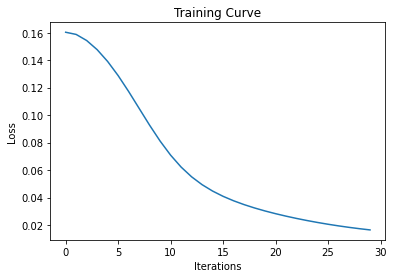

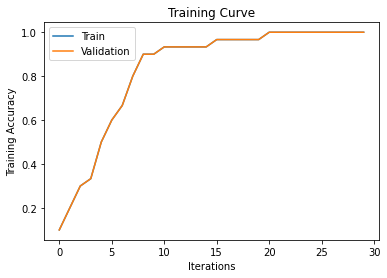

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
#Testing if I can overfit with ResNet
resNetClassify_single_fc_overfit = Waste_Classifier_One_Linear_Layer(name="overfit_Res", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_single_fc_overfit = resNetClassify_single_fc_overfit.cuda()
train(resNetClassify_single_fc_overfit, feature_tiny_set, feature_tiny_set, batch_size=15, num_epochs=30, learning_rate=0.001)

Epoch 1: Train accuracy: 0.11846318036286019, Training Loss: 0.6691821217536926, Validation Accuracy: 0.1111111111111111
Epoch 2: Train accuracy: 0.27908217716115263, Training Loss: 1.3819187879562378, Validation Accuracy: 0.2692307692307692
Epoch 3: Train accuracy: 0.33271077908217717, Training Loss: 0.5319944620132446, Validation Accuracy: 0.32905982905982906
Epoch 4: Train accuracy: 0.4631803628601921, Training Loss: 0.24105893075466156, Validation Accuracy: 0.45085470085470086
Epoch 5: Train accuracy: 0.5669690501600854, Training Loss: 0.26677533984184265, Validation Accuracy: 0.5534188034188035
Epoch 6: Train accuracy: 0.576307363927428, Training Loss: 0.27617838978767395, Validation Accuracy: 0.5726495726495726
Epoch 7: Train accuracy: 0.6061899679829242, Training Loss: 0.13982103765010834, Validation Accuracy: 0.5833333333333334
Epoch 8: Train accuracy: 0.6456776947705443, Training Loss: 0.11193840950727463, Validation Accuracy: 0.6388888888888888
Epoch 9: Train accuracy: 0.6648

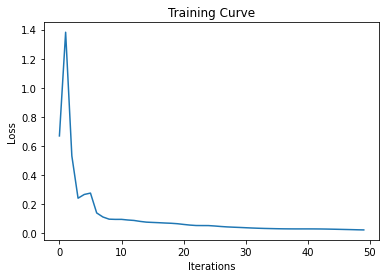

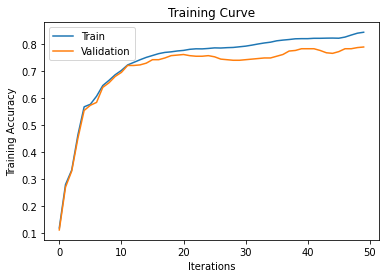

Final Training Accuracy: 0.8431163287086446
Final Validation Accuracy: 0.7884615384615384


In [ ]:
resNetClassify_single_fc = Waste_Classifier_One_Linear_Layer(name="fc_Res", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_single_fc = resNetClassify_single_fc.cuda()
train(resNetClassify_single_fc, feature_train_set, feature_val_set, batch_size=64, num_epochs=50, learning_rate=0.01)

Epoch 1: Train accuracy: 0.11712913553895411, Training Loss: 0.08435904234647751, Validation Accuracy: 0.12179487179487179
Epoch 2: Train accuracy: 0.2870864461045891, Training Loss: 0.1293942630290985, Validation Accuracy: 0.27350427350427353
Epoch 3: Train accuracy: 0.31937033084311633, Training Loss: 0.059752508997917175, Validation Accuracy: 0.3141025641025641
Epoch 4: Train accuracy: 0.4762540021344717, Training Loss: 0.03162379935383797, Validation Accuracy: 0.46794871794871795
Epoch 5: Train accuracy: 0.5656350053361793, Training Loss: 0.03366975858807564, Validation Accuracy: 0.5427350427350427
Epoch 6: Train accuracy: 0.5901814300960512, Training Loss: 0.027573861181735992, Validation Accuracy: 0.5726495726495726
Epoch 7: Train accuracy: 0.6173959445037354, Training Loss: 0.020487414672970772, Validation Accuracy: 0.6004273504273504
Epoch 8: Train accuracy: 0.6464781216648879, Training Loss: 0.017300089821219444, Validation Accuracy: 0.6303418803418803
Epoch 9: Train accuracy:

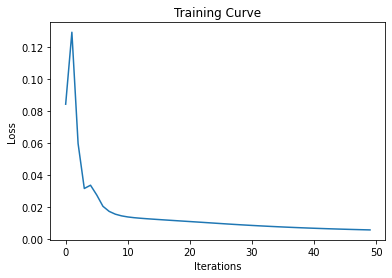

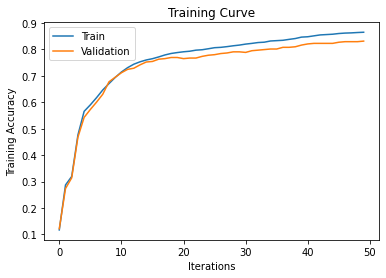

Final Training Accuracy: 0.8647278548559232
Final Validation Accuracy: 0.8311965811965812


In [ ]:
resNetClassify_single_fc_1 = Waste_Classifier_One_Linear_Layer(name="fc_Res_1", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_single_fc_1 = resNetClassify_single_fc_1.cuda()
train(resNetClassify_single_fc_1, feature_train_set, feature_val_set, batch_size=64, num_epochs=50, learning_rate=0.001)

Epoch 1: Train accuracy: 0.25853788687299895, Training Loss: 0.03338064253330231, Validation Accuracy: 0.24786324786324787
Epoch 2: Train accuracy: 0.36312700106723583, Training Loss: 0.04613175243139267, Validation Accuracy: 0.37606837606837606
Epoch 3: Train accuracy: 0.651547491995731, Training Loss: 0.014135117642581463, Validation Accuracy: 0.6452991452991453
Epoch 4: Train accuracy: 0.6889007470651014, Training Loss: 0.011036111041903496, Validation Accuracy: 0.6901709401709402
Epoch 5: Train accuracy: 0.721718249733191, Training Loss: 0.0076577854342758656, Validation Accuracy: 0.7136752136752137
Epoch 6: Train accuracy: 0.7329242262540021, Training Loss: 0.007859270088374615, Validation Accuracy: 0.7350427350427351
Epoch 7: Train accuracy: 0.7491995731056563, Training Loss: 0.006102223880589008, Validation Accuracy: 0.7478632478632479
Epoch 8: Train accuracy: 0.7593383137673426, Training Loss: 0.0068993400782346725, Validation Accuracy: 0.7542735042735043
Epoch 9: Train accurac

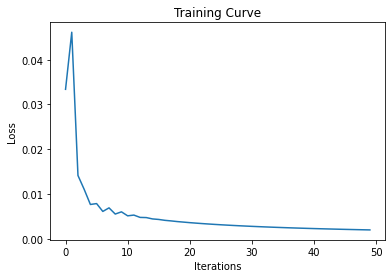

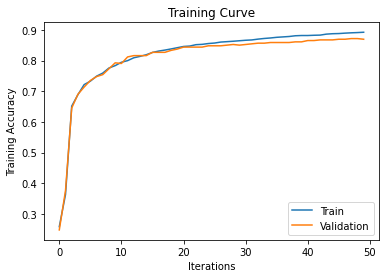

Final Training Accuracy: 0.8924759871931697
Final Validation Accuracy: 0.8696581196581197


In [ ]:
resNetClassify_single_fc_2 = Waste_Classifier_One_Linear_Layer(name="fc_Res_1", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_single_fc_2 = resNetClassify_single_fc_2.cuda()
train(resNetClassify_single_fc_2, feature_train_set, feature_val_set, batch_size=128, num_epochs=50, learning_rate=0.001)

Epoch 1: Train accuracy: 0.25, Training Loss: 0.03335027024149895, Validation Accuracy: 0.23504273504273504
Epoch 2: Train accuracy: 0.3815368196371398, Training Loss: 0.04600542411208153, Validation Accuracy: 0.37393162393162394
Epoch 3: Train accuracy: 0.6507470651013874, Training Loss: 0.013300739228725433, Validation Accuracy: 0.6239316239316239
Epoch 4: Train accuracy: 0.6851654215581644, Training Loss: 0.010633542202413082, Validation Accuracy: 0.6837606837606838
Epoch 5: Train accuracy: 0.7219850586979722, Training Loss: 0.007749849930405617, Validation Accuracy: 0.7136752136752137
Epoch 6: Train accuracy: 0.733991462113127, Training Loss: 0.007662411313503981, Validation Accuracy: 0.7329059829059829
Epoch 7: Train accuracy: 0.7513340448239061, Training Loss: 0.006182793062180281, Validation Accuracy: 0.7457264957264957
Epoch 8: Train accuracy: 0.763607257203842, Training Loss: 0.006684109102934599, Validation Accuracy: 0.7713675213675214
Epoch 9: Train accuracy: 0.7732123799359

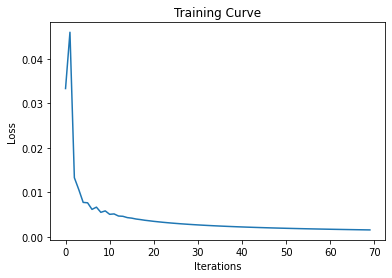

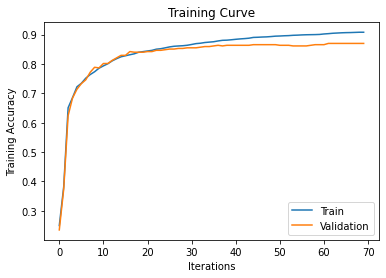

Final Training Accuracy: 0.9076840981856991
Final Validation Accuracy: 0.8696581196581197


In [ ]:
resNetClassify_single_fc_3 = Waste_Classifier_One_Linear_Layer(name="fc_Res_3", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_single_fc_3 = resNetClassify_single_fc_3.cuda()
train(resNetClassify_single_fc_3, feature_train_set, feature_val_set, batch_size=128, num_epochs=70, learning_rate=0.001)

Epoch 1: Train accuracy: 0.20651013874066168, Training Loss: 0.02228613942861557, Validation Accuracy: 0.1987179487179487
Epoch 2: Train accuracy: 0.5506937033084311, Training Loss: 0.0314771942794323, Validation Accuracy: 0.561965811965812
Epoch 3: Train accuracy: 0.6622198505869797, Training Loss: 0.004056478384882212, Validation Accuracy: 0.6709401709401709
Epoch 4: Train accuracy: 0.701974386339381, Training Loss: 0.012500966899096966, Validation Accuracy: 0.6901709401709402
Epoch 5: Train accuracy: 0.7091782283884739, Training Loss: 0.004020610824227333, Validation Accuracy: 0.7029914529914529
Epoch 6: Train accuracy: 0.7483991462113126, Training Loss: 0.006842339411377907, Validation Accuracy: 0.7457264957264957
Epoch 7: Train accuracy: 0.7257203842049093, Training Loss: 0.0037310051266103983, Validation Accuracy: 0.7136752136752137
Epoch 8: Train accuracy: 0.7582710779082177, Training Loss: 0.005001754499971867, Validation Accuracy: 0.75
Epoch 9: Train accuracy: 0.76120597652081

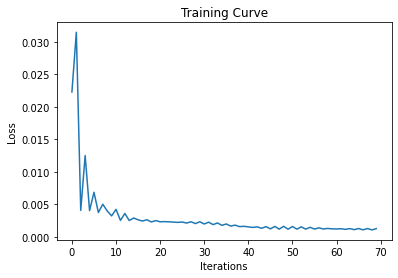

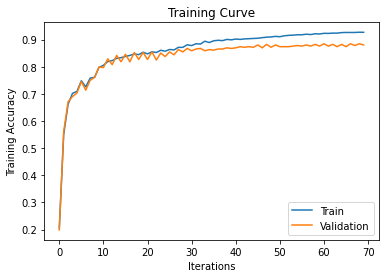

Final Training Accuracy: 0.9268943436499466
Final Validation Accuracy: 0.8803418803418803


In [ ]:
resNetClassify_single_fc_4 = Waste_Classifier_One_Linear_Layer(name="fc_Res_4", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_single_fc_4 = resNetClassify_single_fc_4.cuda()
train(resNetClassify_single_fc_4, feature_train_set, feature_val_set, batch_size=256, num_epochs=70, learning_rate=0.003)

Epoch 1: Train accuracy: 0.285752401280683, Training Loss: 0.010709681548178196, Validation Accuracy: 0.27136752136752135
Epoch 2: Train accuracy: 0.572572038420491, Training Loss: 0.013025179505348206, Validation Accuracy: 0.5790598290598291
Epoch 3: Train accuracy: 0.5952508004268944, Training Loss: 0.0016037413151934743, Validation Accuracy: 0.6111111111111112
Epoch 4: Train accuracy: 0.67982924226254, Training Loss: 0.0032419401686638594, Validation Accuracy: 0.688034188034188
Epoch 5: Train accuracy: 0.7086446104589115, Training Loss: 0.002866933587938547, Validation Accuracy: 0.7243589743589743
Epoch 6: Train accuracy: 0.717982924226254, Training Loss: 0.0010540077928453684, Validation Accuracy: 0.7264957264957265
Epoch 7: Train accuracy: 0.78948772678762, Training Loss: 0.0026760741602629423, Validation Accuracy: 0.7948717948717948
Epoch 8: Train accuracy: 0.7780149413020278, Training Loss: 0.0007111449376679957, Validation Accuracy: 0.7756410256410257
Epoch 9: Train accuracy: 0

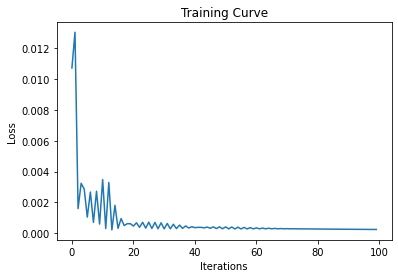

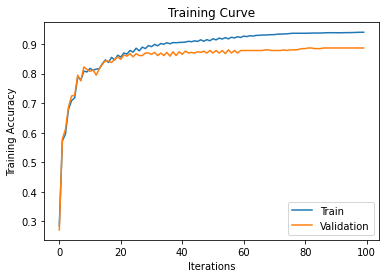

Final Training Accuracy: 0.9399679829242262
Final Validation Accuracy: 0.8867521367521367


In [ ]:
resNetClassify_single_fc_5 = Waste_Classifier_One_Linear_Layer(name="fc_Res_5", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_single_fc_5 = resNetClassify_single_fc_5.cuda()
train(resNetClassify_single_fc_5, feature_train_set, feature_val_set, batch_size=512, num_epochs=100, learning_rate=0.007)

Epoch 1: Train accuracy: 0.23692636072572038, Training Loss: 0.009949414990842342, Validation Accuracy: 0.25213675213675213
Epoch 2: Train accuracy: 0.48906083244397014, Training Loss: 0.01614462397992611, Validation Accuracy: 0.5170940170940171
Epoch 3: Train accuracy: 0.5747065101387406, Training Loss: 0.001470003742724657, Validation Accuracy: 0.5747863247863247
Epoch 4: Train accuracy: 0.6403415154749199, Training Loss: 0.0051556541584432125, Validation Accuracy: 0.6602564102564102
Epoch 5: Train accuracy: 0.6430096051227321, Training Loss: 0.0017918922239914536, Validation Accuracy: 0.6517094017094017
Epoch 6: Train accuracy: 0.7131803628601922, Training Loss: 0.0020972066558897495, Validation Accuracy: 0.7393162393162394
Epoch 7: Train accuracy: 0.791889007470651, Training Loss: 0.0008650576346553862, Validation Accuracy: 0.7905982905982906
Epoch 8: Train accuracy: 0.7836179295624333, Training Loss: 0.0022583045065402985, Validation Accuracy: 0.7863247863247863
Epoch 9: Train acc

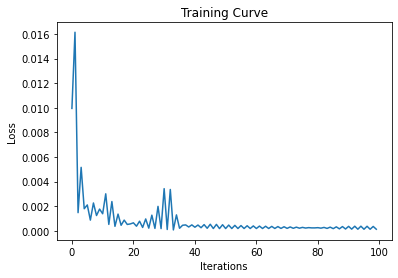

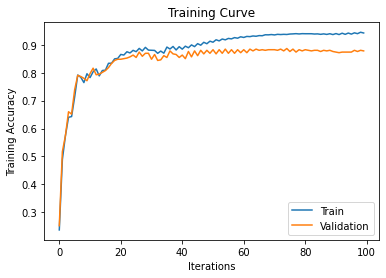

Final Training Accuracy: 0.9423692636072573
Final Validation Accuracy: 0.8782051282051282


In [ ]:
resNetClassify_single_fc_6 = Waste_Classifier_One_Linear_Layer(name="fc_Res_6", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_single_fc_6 = resNetClassify_single_fc_6.cuda()
train(resNetClassify_single_fc_6, feature_train_set, feature_val_set, batch_size=512, num_epochs=100, learning_rate=0.009)

In [ ]:
# Set up data with augmentations
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transformations_resnet = transforms.Compose([                                     
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)  
])

transformations_resnet_augment = transforms.Compose([                                     
  transforms.Resize((224,224)),
  transforms.ColorJitter(),
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  transforms.RandomRotation(30, interpolation=transforms.InterpolationMode.BILINEAR),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)  
])

train_set = torchvision.datasets.ImageFolder(train_path, transform = transformations_resnet_augment)
val_set = torchvision.datasets.ImageFolder(val_path, transform = transformations_resnet)
test_set = torchvision.datasets.ImageFolder(test_path, transform = transformations_resnet)
tiny_set = torchvision.datasets.ImageFolder(tiny_path, transform = transformations_resnet)


In [ ]:
# Save resnet18 features for augmentations
data_dir = '/root/datasets/ResNet_augment/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

os.mkdir(data_dir)
save_features(model.cuda(), "ResNetAugment", tiny_set, tiny_dir, tiny_set.classes)
save_features(model.cuda(), "ResNetAugment", train_set, train_dir, train_set.classes)
save_features(model.cuda(), "ResNetAugment", val_set, val_dir, val_set.classes)
save_features(model.cuda(), "ResNetAugment", test_set, test_dir, test_set.classes)
feature_tiny_set = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.13333333333333333, Training Loss: 0.14645684560139974, Validation Accuracy: 0.13333333333333333
Epoch 11: Train accuracy: 0.9666666666666667, Training Loss: 0.06703584988911947, Validation Accuracy: 0.9666666666666667
Epoch 21: Train accuracy: 1.0, Training Loss: 0.026328017314275105, Validation Accuracy: 1.0


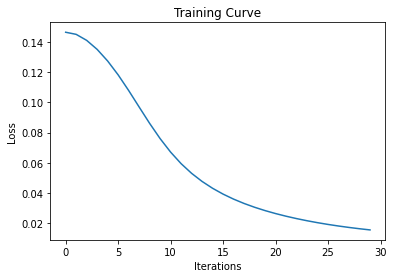

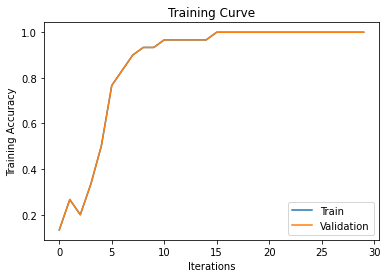

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
#Testing if I can overfit with ResNet
resNetClassify_augment_overfit = Waste_Classifier_One_Linear_Layer(name="overfit_Res_aug", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_augment_overfit = resNetClassify_augment_overfit.cuda()
train(resNetClassify_augment_overfit, feature_tiny_set, feature_tiny_set, batch_size=15, num_epochs=30, learning_rate=0.001)

Epoch 1: Train accuracy: 0.15768409818569903, Training Loss: 0.006809299811720848, Validation Accuracy: 0.15384615384615385
Epoch 11: Train accuracy: 0.628068303094984, Training Loss: 0.0017697940347716212, Validation Accuracy: 0.6666666666666666
Epoch 21: Train accuracy: 0.6939701173959445, Training Loss: 0.0014312396524474025, Validation Accuracy: 0.7243589743589743
Epoch 31: Train accuracy: 0.7147812166488794, Training Loss: 0.001264615566469729, Validation Accuracy: 0.7564102564102564
Epoch 41: Train accuracy: 0.7329242262540021, Training Loss: 0.0011557636316865683, Validation Accuracy: 0.7670940170940171
Epoch 51: Train accuracy: 0.7435965848452508, Training Loss: 0.0010758504504337907, Validation Accuracy: 0.7735042735042735
Epoch 61: Train accuracy: 0.7529348986125933, Training Loss: 0.0010133904870599508, Validation Accuracy: 0.7735042735042735
Epoch 71: Train accuracy: 0.7638740661686233, Training Loss: 0.000962574384175241, Validation Accuracy: 0.7841880341880342
Epoch 81: T

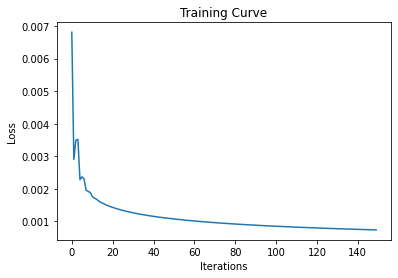

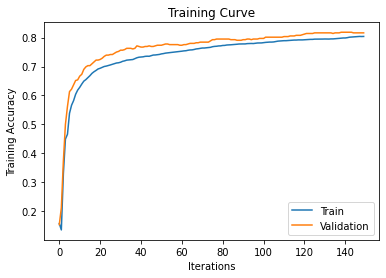

Final Training Accuracy: 0.8038954108858057
Final Validation Accuracy: 0.8162393162393162


In [ ]:
resNetClassify_augment_1 = Waste_Classifier_One_Linear_Layer(name="Res_aug_1", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_augment_1 = resNetClassify_augment_1.cuda()
train(resNetClassify_augment_1, feature_train_set, feature_val_set, batch_size=512, num_epochs=150, learning_rate=0.001)

Epoch 1: Train accuracy: 0.18356456776947705, Training Loss: 0.006272358354181051, Validation Accuracy: 0.19658119658119658
Epoch 11: Train accuracy: 0.6923692636072573, Training Loss: 0.0016018388560041785, Validation Accuracy: 0.717948717948718
Epoch 21: Train accuracy: 0.7297225186766275, Training Loss: 0.0012962962500751019, Validation Accuracy: 0.7670940170940171
Epoch 31: Train accuracy: 0.7524012806830309, Training Loss: 0.0011330730048939586, Validation Accuracy: 0.7884615384615384
Epoch 41: Train accuracy: 0.7710779082177162, Training Loss: 0.0010250380728393793, Validation Accuracy: 0.7970085470085471
Epoch 51: Train accuracy: 0.7836179295624333, Training Loss: 0.0009459895081818104, Validation Accuracy: 0.7948717948717948
Epoch 61: Train accuracy: 0.7940234791889007, Training Loss: 0.0008844388648867607, Validation Accuracy: 0.8012820512820513
Epoch 71: Train accuracy: 0.8030949839914621, Training Loss: 0.0008344266680069268, Validation Accuracy: 0.8076923076923077
Epoch 81:

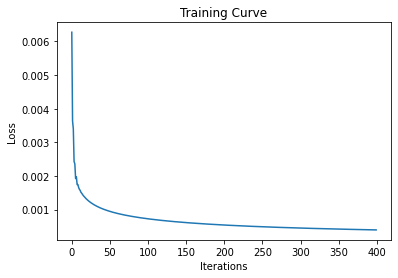

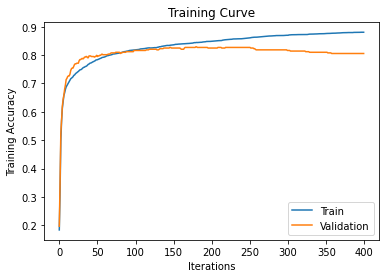

Final Training Accuracy: 0.880469583778015
Final Validation Accuracy: 0.8055555555555556


In [ ]:
resNetClassify_augment_2 = Waste_Classifier_One_Linear_Layer(name="Res_aug_2", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_augment_2 = resNetClassify_augment_2.cuda()
train(resNetClassify_augment_2, feature_train_set, feature_val_set, batch_size=512, num_epochs=400, learning_rate=0.002)

Epoch 1: Train accuracy: 0.15314834578441835, Training Loss: 0.0013717581750825047, Validation Accuracy: 0.19017094017094016
Epoch 11: Train accuracy: 0.6723585912486659, Training Loss: 0.0005109916673973203, Validation Accuracy: 0.6773504273504274
Epoch 21: Train accuracy: 0.727854855923159, Training Loss: 0.0004044725501444191, Validation Accuracy: 0.7371794871794872
Epoch 31: Train accuracy: 0.7556029882604055, Training Loss: 0.0003674964827951044, Validation Accuracy: 0.7670940170940171
Epoch 41: Train accuracy: 0.7774813233724653, Training Loss: 0.00034066123771481216, Validation Accuracy: 0.7777777777777778
Epoch 51: Train accuracy: 0.7921558164354322, Training Loss: 0.00032290228409692645, Validation Accuracy: 0.7884615384615384
Epoch 61: Train accuracy: 0.8038954108858057, Training Loss: 0.00030895110103301704, Validation Accuracy: 0.8012820512820513
Epoch 71: Train accuracy: 0.8094983991462114, Training Loss: 0.0002974775561597198, Validation Accuracy: 0.8012820512820513
Epoch

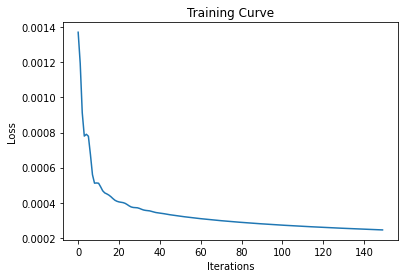

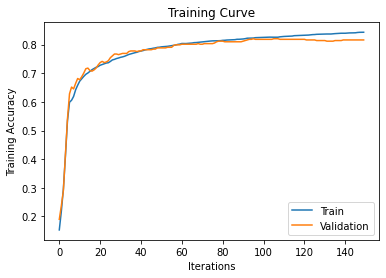

Final Training Accuracy: 0.8431163287086446
Final Validation Accuracy: 0.8162393162393162


In [ ]:
resNetClassify_augment_3 = Waste_Classifier_One_Linear_Layer(name="Res_aug_3", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_augment_3 = resNetClassify_augment_3.cuda()
train(resNetClassify_augment_3, feature_train_set, feature_val_set, batch_size=2048, num_epochs=150, learning_rate=0.009)

Epoch 1: Train accuracy: 0.0672358591248666, Training Loss: 0.002268135314807296, Validation Accuracy: 0.06196581196581197
Epoch 11: Train accuracy: 0.2195837780149413, Training Loss: 0.0019673414062708616, Validation Accuracy: 0.25427350427350426
Epoch 21: Train accuracy: 0.3623265741728922, Training Loss: 0.001597673981450498, Validation Accuracy: 0.37606837606837606
Epoch 31: Train accuracy: 0.49172892209178226, Training Loss: 0.0012202695943415165, Validation Accuracy: 0.4893162393162393
Epoch 41: Train accuracy: 0.6093916755602988, Training Loss: 0.0008463480626232922, Validation Accuracy: 0.5961538461538461
Epoch 51: Train accuracy: 0.6606189967982924, Training Loss: 0.0007168729207478464, Validation Accuracy: 0.6709401709401709
Epoch 61: Train accuracy: 0.7051760939167556, Training Loss: 0.0006510874954983592, Validation Accuracy: 0.6965811965811965
Epoch 71: Train accuracy: 0.7310565635005336, Training Loss: 0.0006000899011269212, Validation Accuracy: 0.717948717948718
Epoch 81

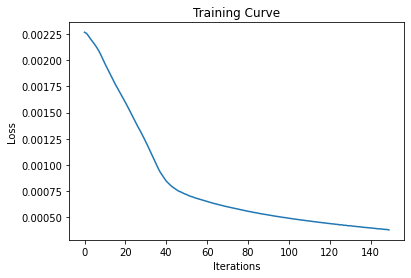

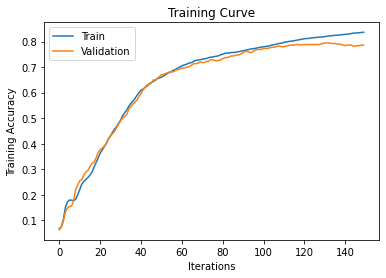

Final Training Accuracy: 0.8367129135538954
Final Validation Accuracy: 0.7863247863247863


In [ ]:
resNetClassify_augment_x1 = Waste_Classifier_MLP(name="Res_aug_x1", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_augment_x1 = resNetClassify_augment_x1.cuda()
train(resNetClassify_augment_x1, feature_train_set, feature_val_set, batch_size=1024, num_epochs=150, learning_rate=0.005)

In [ ]:
# Try resnet18 with CNN extractor
model = copy.deepcopy(resnet18)
model = nn.Sequential(*(list(resnet18.children())[0:8]))
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Save resnet18 features for augmentations with CNN
data_dir = '/root/datasets/ResNet_augmentCNN/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

os.mkdir(data_dir)
save_features(model.cuda(), "ResNetAugmentCNN", tiny_set, tiny_dir, tiny_set.classes)
save_features(model.cuda(), "ResNetAugmentCNN", train_set, train_dir, train_set.classes)
save_features(model.cuda(), "ResNetAugmentCNN", val_set, val_dir, val_set.classes)
save_features(model.cuda(), "ResNetAugmentCNN", test_set, test_dir, test_set.classes)
feature_tiny_set = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.0963180362860192, Training Loss: 0.0048027001321315765, Validation Accuracy: 0.10042735042735043
Epoch 11: Train accuracy: 0.3663287086446105, Training Loss: 0.002783516887575388, Validation Accuracy: 0.4081196581196581
Epoch 21: Train accuracy: 0.5925827107790822, Training Loss: 0.001807830180041492, Validation Accuracy: 0.5961538461538461
Epoch 31: Train accuracy: 0.6878335112059765, Training Loss: 0.0014789907727390528, Validation Accuracy: 0.6901709401709402
Epoch 41: Train accuracy: 0.7390608324439701, Training Loss: 0.0011545737506821752, Validation Accuracy: 0.7307692307692307
Epoch 51: Train accuracy: 0.7748132337246532, Training Loss: 0.0009097719448618591, Validation Accuracy: 0.7542735042735043
Epoch 61: Train accuracy: 0.8068303094983992, Training Loss: 0.0007206485606729984, Validation Accuracy: 0.7777777777777778
Epoch 71: Train accuracy: 0.8313767342582711, Training Loss: 0.000578262668568641, Validation Accuracy: 0.7841880341880342
Epoch 81: T

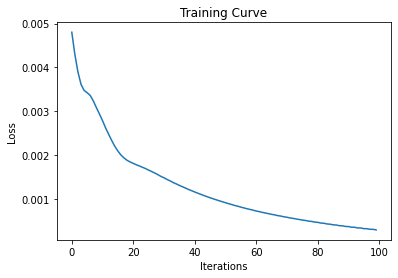

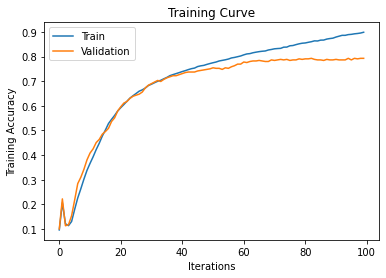

Final Training Accuracy: 0.8986125933831377
Final Validation Accuracy: 0.7927350427350427


In [ ]:
resNetClassify_augment_4 = Waste_Classifier_CNN_With_Pool(name="Res_aug_3", hidden_size=512, filtered_dim_size=1)
if use_cuda and torch.cuda.is_available():
  resNetClassify_augment_4 = resNetClassify_augment_4.cuda()
train(resNetClassify_augment_4, feature_train_set, feature_val_set, batch_size=512, num_epochs=100, learning_rate=0.001)

Epoch 1: Train accuracy: 0.1824973319103522, Training Loss: 0.0048064133152365685, Validation Accuracy: 0.1794871794871795
Epoch 11: Train accuracy: 0.5280149413020278, Training Loss: 0.002392565831542015, Validation Accuracy: 0.5512820512820513
Epoch 21: Train accuracy: 0.6856990394877268, Training Loss: 0.0015070292865857482, Validation Accuracy: 0.6773504273504274
Epoch 31: Train accuracy: 0.7577374599786553, Training Loss: 0.0010393676348030567, Validation Accuracy: 0.7243589743589743
Epoch 41: Train accuracy: 0.8094983991462114, Training Loss: 0.000764459022320807, Validation Accuracy: 0.7670940170940171
Epoch 51: Train accuracy: 0.8425827107790822, Training Loss: 0.0005699158064089715, Validation Accuracy: 0.7970085470085471
Epoch 61: Train accuracy: 0.871931696905016, Training Loss: 0.000435482244938612, Validation Accuracy: 0.7948717948717948
Epoch 71: Train accuracy: 0.8900747065101388, Training Loss: 0.0003560656332410872, Validation Accuracy: 0.7991452991452992
Epoch 81: Tra

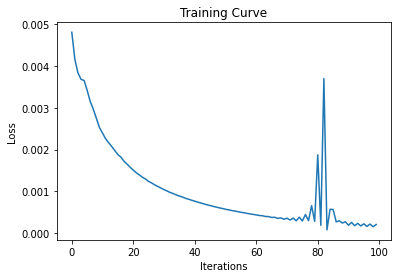

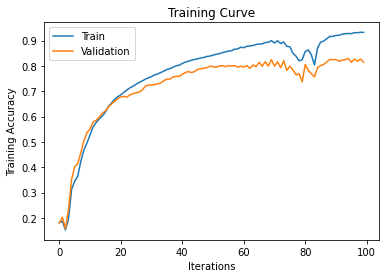

Final Training Accuracy: 0.9319637139807898
Final Validation Accuracy: 0.8141025641025641


In [ ]:
resNetClassify_augment_5 = Waste_Classifier_One_CNN_Layer(name="Res_aug_5", hidden_size=512, filtered_dim_size=3)
if use_cuda and torch.cuda.is_available():
  resNetClassify_augment_5 = resNetClassify_augment_5.cuda()
train(resNetClassify_augment_5, feature_train_set, feature_val_set, batch_size=512, num_epochs=100, learning_rate=0.001)

Epoch 1: Train accuracy: 0.10805763073639274, Training Loss: 0.0024868729524314404, Validation Accuracy: 0.1047008547008547
Epoch 11: Train accuracy: 0.5538954108858057, Training Loss: 0.0013588272267952561, Validation Accuracy: 0.6004273504273504
Epoch 21: Train accuracy: 0.6808964781216649, Training Loss: 0.000824190559796989, Validation Accuracy: 0.7051282051282052
Epoch 31: Train accuracy: 0.7371931696905016, Training Loss: 0.0006516274879686534, Validation Accuracy: 0.7371794871794872
Epoch 41: Train accuracy: 0.7732123799359658, Training Loss: 0.0005520168924704194, Validation Accuracy: 0.7606837606837606
Epoch 51: Train accuracy: 0.8030949839914621, Training Loss: 0.0004798355221282691, Validation Accuracy: 0.7927350427350427
Epoch 61: Train accuracy: 0.8271077908217717, Training Loss: 0.0004234997322782874, Validation Accuracy: 0.8055555555555556
Epoch 71: Train accuracy: 0.8476520811099253, Training Loss: 0.0003758355451282114, Validation Accuracy: 0.8055555555555556
Epoch 81:

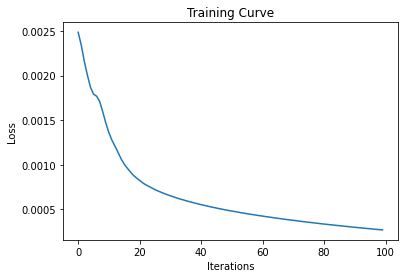

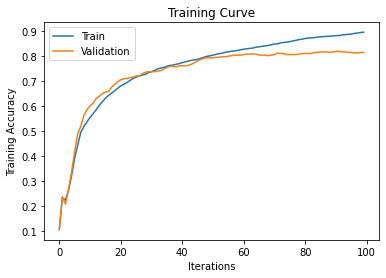

Final Training Accuracy: 0.8948772678762006
Final Validation Accuracy: 0.8141025641025641


In [ ]:
resNetClassify_augment_6 = Waste_Classifier_One_CNN_Layer(name="Res_aug_6", hidden_size=512, filtered_dim_size=3)
if use_cuda and torch.cuda.is_available():
  resNetClassify_augment_6 = resNetClassify_augment_6.cuda()
train(resNetClassify_augment_6, feature_train_set, feature_val_set, batch_size=1024, num_epochs=100, learning_rate=0.001)

Epoch 1: Train accuracy: 0.07524012806830309, Training Loss: 0.002367163309827447, Validation Accuracy: 0.0811965811965812
Epoch 11: Train accuracy: 0.4757203842049093, Training Loss: 0.0016501471400260925, Validation Accuracy: 0.5192307692307693
Epoch 21: Train accuracy: 0.5952508004268944, Training Loss: 0.0011341620702296495, Validation Accuracy: 0.6410256410256411
Epoch 31: Train accuracy: 0.6686232657417289, Training Loss: 0.0008605307666584849, Validation Accuracy: 0.6923076923076923
Epoch 41: Train accuracy: 0.7075773745997865, Training Loss: 0.0007217339589260519, Validation Accuracy: 0.7200854700854701
Epoch 51: Train accuracy: 0.7361259338313767, Training Loss: 0.0006370567134581506, Validation Accuracy: 0.7350427350427351
Epoch 61: Train accuracy: 0.7588046958377801, Training Loss: 0.0005762636428698897, Validation Accuracy: 0.7457264957264957
Epoch 71: Train accuracy: 0.7753468516542156, Training Loss: 0.0005283625796437263, Validation Accuracy: 0.7564102564102564
Epoch 81:

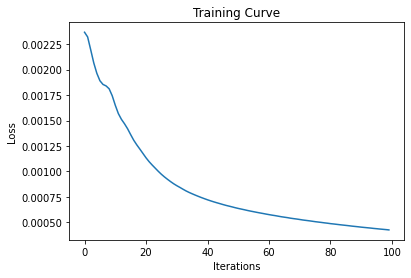

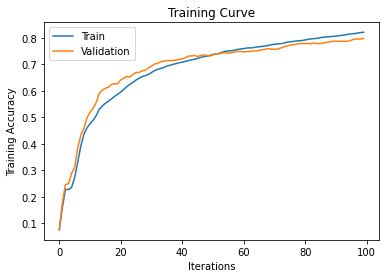

Final Training Accuracy: 0.8204375667022412
Final Validation Accuracy: 0.7970085470085471


In [ ]:
resNetClassify_augment_7 = Waste_Classifier_One_CNN_Layer(name="Res_aug_7", hidden_size=512, filtered_dim_size=3)
if use_cuda and torch.cuda.is_available():
  resNetClassify_augment_7 = resNetClassify_augment_7.cuda()
train(resNetClassify_augment_7, feature_train_set, feature_val_set, batch_size=1024, num_epochs=100, learning_rate=0.0005)


# Predictions and Testing --> ResNet152

In [33]:
# Load the tensors
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transformations = transforms.Compose([                                     
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)  
])
train_set = torchvision.datasets.ImageFolder(train_path, transform = transformations)
val_set = torchvision.datasets.ImageFolder(val_path, transform = transformations)
test_set = torchvision.datasets.ImageFolder(test_path, transform = transformations)
tiny_set = torchvision.datasets.ImageFolder(tiny_path, transform = transformations)

In [34]:
model = resnet152
model = nn.Sequential(*(list(resnet152.children())[0:9]))
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [35]:
# Save resnet152 features
data_dir = '/root/datasets/ResNet152/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

os.mkdir(data_dir)
save_features(model.cuda(), "ResNet152", tiny_set, tiny_dir, tiny_set.classes)
save_features(model.cuda(), "ResNet152", train_set, train_dir, train_set.classes)
save_features(model.cuda(), "ResNet152", val_set, val_dir, val_set.classes)
save_features(model.cuda(), "ResNet152", test_set, test_dir, test_set.classes)
feature_tiny_set = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.3, Training Loss: 0.16004139582316082, Validation Accuracy: 0.3
Epoch 11: Train accuracy: 1.0, Training Loss: 0.0037403225898742674, Validation Accuracy: 1.0
Epoch 21: Train accuracy: 1.0, Training Loss: 0.0010263998061418532, Validation Accuracy: 1.0
Epoch 31: Train accuracy: 1.0, Training Loss: 0.0007183605184157689, Validation Accuracy: 1.0
Epoch 41: Train accuracy: 1.0, Training Loss: 0.0006107461949189503, Validation Accuracy: 1.0


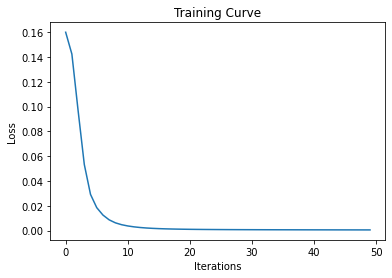

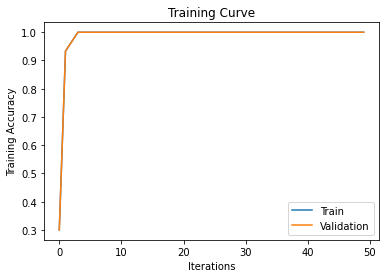

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
#Testing if I can overfit with ResNet152
res152_overfit = Waste_Classifier_One_Linear_Layer(name="overfit_Res", hidden_size=2048*1*1)
if use_cuda and torch.cuda.is_available():
  res152_overfit = res152_overfit.cuda()
train(res152_overfit, feature_tiny_set, feature_tiny_set, batch_size=15, num_epochs=50, learning_rate=0.005)

Epoch 1: Train accuracy: 0.12753468516542155, Training Loss: 0.4525664746761322, Validation Accuracy: 0.1282051282051282
Epoch 11: Train accuracy: 0.7972251867662753, Training Loss: 0.016541434451937675, Validation Accuracy: 0.7970085470085471
Epoch 21: Train accuracy: 0.8943436499466382, Training Loss: 0.00013102164666634053, Validation Accuracy: 0.8717948717948718
Epoch 31: Train accuracy: 0.913820704375667, Training Loss: 4.269430064596236e-05, Validation Accuracy: 0.8717948717948718
Epoch 41: Train accuracy: 0.8775346851654215, Training Loss: 0.0067498586140573025, Validation Accuracy: 0.8418803418803419


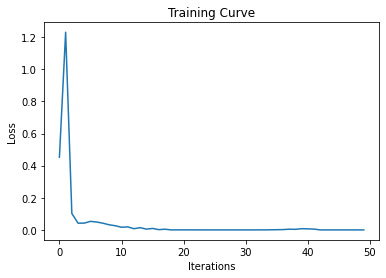

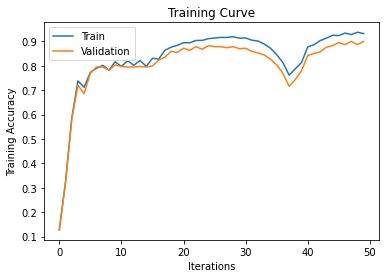

Final Training Accuracy: 0.9316969050160085
Final Validation Accuracy: 0.8995726495726496


In [ ]:
res152_1 = Waste_Classifier_One_Linear_Layer(name="overfit_Res", hidden_size=2048*1*1)
if use_cuda and torch.cuda.is_available():
  res152_1 = res152_1.cuda()
train(res152_1, feature_train_set, feature_val_set, batch_size=128, num_epochs=50, learning_rate=0.02)

Epoch 1: Train accuracy: 0.2865528281750267, Training Loss: 0.010168981738388538, Validation Accuracy: 0.27350427350427353
Epoch 11: Train accuracy: 0.8703308431163287, Training Loss: 0.0005736697930842638, Validation Accuracy: 0.8568376068376068
Epoch 21: Train accuracy: 0.8994130202774814, Training Loss: 0.0004934972384944558, Validation Accuracy: 0.8717948717948718
Epoch 31: Train accuracy: 0.9212913553895411, Training Loss: 0.00031211963505484164, Validation Accuracy: 0.8846153846153846
Epoch 41: Train accuracy: 0.9332977588046958, Training Loss: 0.0002559347776696086, Validation Accuracy: 0.8995726495726496
Epoch 51: Train accuracy: 0.9394343649946638, Training Loss: 0.00021719811775255948, Validation Accuracy: 0.8995726495726496
Epoch 61: Train accuracy: 0.9463713980789754, Training Loss: 0.0001900956267490983, Validation Accuracy: 0.8974358974358975
Epoch 71: Train accuracy: 0.9522411953041622, Training Loss: 0.0001721459411783144, Validation Accuracy: 0.8974358974358975
Epoch 8

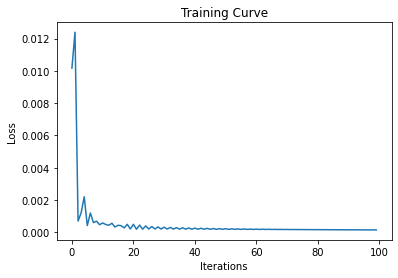

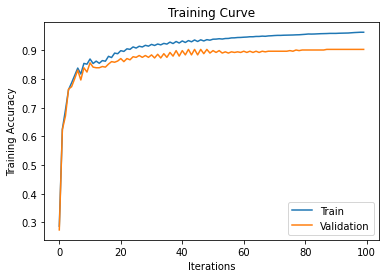

Final Training Accuracy: 0.9637139807897546
Final Validation Accuracy: 0.9038461538461539


In [36]:
res152_2 = Waste_Classifier_One_Linear_Layer(name="res152_2", hidden_size=2048*1*1)
if use_cuda and torch.cuda.is_available():
  res152_2 = res152_2.cuda()
train(res152_2, feature_train_set, feature_val_set, batch_size=512, num_epochs=100, learning_rate=0.007)

In [ ]:
val_loader = torch.utils.data.DataLoader(feature_val_set, batch_size=1, num_workers=1)
print("Overall accuracy:", get_sorting_accuracy(res152_2, val_loader, 0.5))

Overall accuracy: 0.9572649572649573


In [24]:
from PIL import Image
import torchvision.transforms.functional as TF

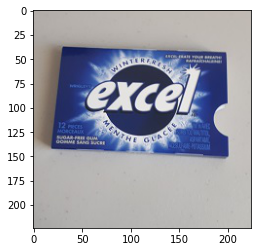

In [30]:
image1 = Image.open('/content/gdrive/MyDrive/APS360 Group Project/Example Images/Excel_Cropped.jpg')
plt.imshow(np.asarray(image1))

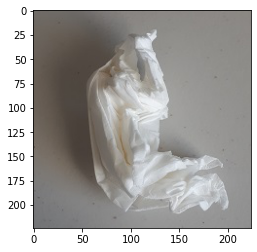

In [31]:
image2 = Image.open('/content/gdrive/MyDrive/APS360 Group Project/Example Images/Tissue_Cropped.jpg')
plt.imshow(np.asarray(image2))

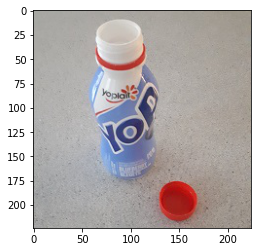

In [32]:
image3 = Image.open('/content/gdrive/MyDrive/APS360 Group Project/Example Images/Yop_Cropped.jpg')
plt.imshow(np.asarray(image3))

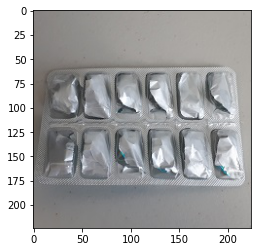

In [43]:
image4 = Image.open('/content/gdrive/MyDrive/APS360 Group Project/Example Images/Gum_Cropped.jpg')
plt.imshow(np.asarray(image4))

In [40]:
train_set.classes

['compost_food',
 'compost_other',
 'garbage',
 'recy_bags',
 'recy_bottles',
 'recy_cans',
 'recy_cups',
 'recy_other_containers',
 'recy_paper',
 'recy_styrofoam']

In [39]:
input_image1 = transformations(image1)
if use_cuda and torch.cuda.is_available():
  input_image1 = input_image1.cuda()
  model_cuda = model.cuda()
  pred1 = model_cuda(input_image1[None, ...])
else:
  pred1 = model(input_image1[None, ...])
pred1_out = res152_2(pred1)
print(pred1_out)

tensor([[-3.7070, -2.1174,  3.8375, -0.7530, -3.2129,  5.0922, -4.6152,  0.3469,
          4.2448, -1.1050]], device='cuda:0', grad_fn=<AddmmBackward>)


This would be classified as a can, which is recycling, however it is in fact a paper product which is also recycling.

In [41]:
input_image2 = transformations(image2)
if use_cuda and torch.cuda.is_available():
  input_image2 = input_image2.cuda()
  model_cuda = model.cuda()
  pred2 = model_cuda(input_image2[None, ...])
else:
  pred2 = model(input_image2[None, ...])
pred2_out = res152_2(pred2)
print(pred2_out)

tensor([[-2.7079,  6.6625,  4.0277,  4.2400, -1.0520, -1.5858, -6.7928, -3.5925,
         -3.1437,  2.7899]], device='cuda:0', grad_fn=<AddmmBackward>)


This has been classified as compost-other which is a subset of compost. This is in fact compost and is not food, so this was accurately predicted.

In [42]:
input_image3 = transformations(image3)
if use_cuda and torch.cuda.is_available():
  input_image3 = input_image3.cuda()
  model_cuda = model.cuda()
  pred3 = model_cuda(input_image3[None, ...])
else:
  pred3 = model(input_image3[None, ...])
pred3_out = res152_2(pred3)
print(pred3_out)

tensor([[-2.0263, -3.2033,  2.1874, -5.8187,  1.7918,  3.2847,  2.5492,  5.8069,
         -5.1885, -0.4650]], device='cuda:0', grad_fn=<AddmmBackward>)


This has been classified as a generic container type, which is recycling. The item is technically a bottle, however has significant differences from most bottles so it could reasonably be classified as a container

In [44]:
input_image4 = transformations(image4)
if use_cuda and torch.cuda.is_available():
  input_image4 = input_image4.cuda()
  model_cuda = model.cuda()
  pred4 = model_cuda(input_image4[None, ...])
else:
  pred4 = model(input_image4[None, ...])
pred4_out = res152_2(pred4)
print(pred4_out)

tensor([[-4.0295, -1.2457,  7.9662, -4.0211, -0.0400,  7.8237, -4.5413, -5.4006,
         -0.4279,  2.3220]], device='cuda:0', grad_fn=<AddmmBackward>)


This has been classified as garbage. This label is correct

# Predictions and Testing --> Inception

Got up to 89% accuracy.

In [ ]:
inception = torchvision.models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [ ]:
# Load the tensors
transformations_inception = transforms.Compose([                                     
  transforms.Resize((299,299)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# torch.manual_seed(1000)
transformations_inception_augment = transforms.Compose([                                     
  transforms.Resize((299,299)),
  transforms.ColorJitter(brightness=0.05, hue=.05, contrast=0.05, saturation=.05),
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  transforms.RandomRotation(30, interpolation=transforms.InterpolationMode.BILINEAR),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

train_set_inception = torchvision.datasets.ImageFolder(train_path, transform=transformations_inception_augment)
val_set_inception = torchvision.datasets.ImageFolder(val_path, transform=transformations_inception)
test_set_inception = torchvision.datasets.ImageFolder(test_path, transform=transformations_inception)
tiny_set_inception = torchvision.datasets.ImageFolder(tiny_path, transform=transformations_inception)

In [ ]:
inception.fc = nn.Identity()
inception.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
data_dir = '/root/datasets/Inception/'
! rm -rf /root/datasets/Inception/

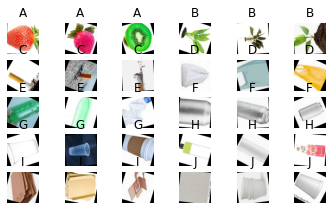

In [ ]:
def view_images(dataset):
  loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=1)
  k = 0
  classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
  current_label_ind = 0
  for images, label in loader:
      if (classes[current_label_ind] == classes[label[0]]):
          # since batch_size = 1, there is only 1 image in `images`
          image = images[0]
          # place the colour channel at the end, instead of at the beginning
          img = np.transpose(image)
          # normalize pixel intensity values to [0, 1]
          img = img / 2 + 0.5
          plt.subplot(6, 6, k+1)
          plt.axis('off')
          plt.title(classes[label[0]])
          plt.imshow(img)

          k += 1
          if k % 3 == 0:
            current_label_ind += 1
            if (current_label_ind == 10):
                break

view_images(train_set_inception)



In [ ]:
# save inception features
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'
use_cuda = True
os.mkdir(data_dir)
model = inception.cuda()
save_features(model, "inception", tiny_set_inception, tiny_dir, tiny_set_inception.classes)
save_features(model, "inception", train_set_inception, train_dir, train_set_inception.classes, num_iter=5)
save_features(model, "inception", val_set_inception, val_dir, val_set_inception.classes)
save_features(model, "inception", test_set_inception, test_dir, test_set_inception.classes)


In [ ]:
feature_tiny_set_inception = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set_inception = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set_inception = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set_inception = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.03333333333333333, Training Loss: 0.07745150725046794, Validation Accuracy: 0.03333333333333333
Epoch 2: Train accuracy: 0.03333333333333333, Training Loss: 0.07734755674997966, Validation Accuracy: 0.03333333333333333
Epoch 3: Train accuracy: 0.03333333333333333, Training Loss: 0.07715221246083577, Validation Accuracy: 0.03333333333333333
Epoch 4: Train accuracy: 0.06666666666666667, Training Loss: 0.07687731583913167, Validation Accuracy: 0.06666666666666667
Epoch 5: Train accuracy: 0.1, Training Loss: 0.07652969360351562, Validation Accuracy: 0.1
Epoch 6: Train accuracy: 0.13333333333333333, Training Loss: 0.07612125873565674, Validation Accuracy: 0.13333333333333333
Epoch 7: Train accuracy: 0.2, Training Loss: 0.0756756067276001, Validation Accuracy: 0.2
Epoch 8: Train accuracy: 0.3, Training Loss: 0.07519900798797607, Validation Accuracy: 0.3
Epoch 9: Train accuracy: 0.4, Training Loss: 0.07469326655069987, Validation Accuracy: 0.4
Epoch 10: Train accura

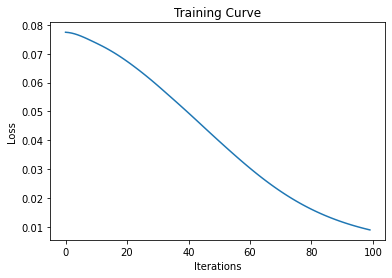

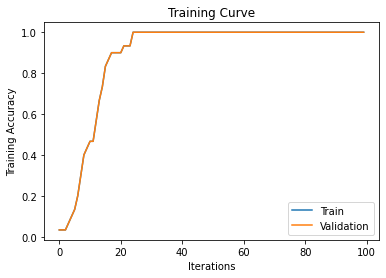

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
#Testing if I can overfit with Inception
inceptionClassify = Waste_Classifier_ANN(name="Waste_Inception", hidden_size=2048)
if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_tiny_set_inception, feature_tiny_set_inception, batch_size=30, num_epochs=100, learning_rate=0.002)

In [ ]:
inceptionClassify = Waste_Classifier_ANN(name="Waste_InceptionANN", hidden_size=2048)
if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_train_set_inception, feature_val_set_inception, batch_size=128, num_epochs=120, learning_rate=0.002)

Epoch 1: Train accuracy: 0.18996798292422626, Training Loss: 0.019606580957770348, Validation Accuracy: 0.17307692307692307
Epoch 2: Train accuracy: 0.16568836712913554, Training Loss: 0.01873674988746643, Validation Accuracy: 0.17735042735042736
Epoch 3: Train accuracy: 0.24946638207043756, Training Loss: 0.018812483176589012, Validation Accuracy: 0.2329059829059829
Epoch 4: Train accuracy: 0.25933831376734257, Training Loss: 0.018639596179127693, Validation Accuracy: 0.25213675213675213
Epoch 5: Train accuracy: 0.30389541088580574, Training Loss: 0.017276188358664513, Validation Accuracy: 0.31837606837606836
Epoch 6: Train accuracy: 0.36312700106723583, Training Loss: 0.01730886846780777, Validation Accuracy: 0.37606837606837606
Epoch 7: Train accuracy: 0.422358591248666, Training Loss: 0.016573091968894005, Validation Accuracy: 0.4166666666666667
Epoch 8: Train accuracy: 0.5146744930629669, Training Loss: 0.01618642359972, Validation Accuracy: 0.5213675213675214
Epoch 9: Train accur

Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x7fdb858293b0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 109, in remove
    def remove(wr, selfref=ref(self), _atomic_removal=_remove_dead_weakref):
KeyboardInterrupt


Epoch 120: Train accuracy: 0.9743863393810032, Training Loss: 0.00030791189055889845, Validation Accuracy: 0.8931623931623932
Epoch 121: Train accuracy: 0.9749199573105657, Training Loss: 0.00030642864294350147, Validation Accuracy: 0.8931623931623932
Epoch 122: Train accuracy: 0.9751867662753468, Training Loss: 0.0003012650413438678, Validation Accuracy: 0.8888888888888888
Epoch 123: Train accuracy: 0.9762540021344717, Training Loss: 0.00029478961369022727, Validation Accuracy: 0.8910256410256411


KeyboardInterrupt: ignored

Epoch 1: Train accuracy: 0.12860192102454643, Training Loss: 0.018631301820278168, Validation Accuracy: 0.13247863247863248
Epoch 2: Train accuracy: 0.1536819637139808, Training Loss: 0.018326394259929657, Validation Accuracy: 0.16666666666666666
Epoch 3: Train accuracy: 0.21611526147278548, Training Loss: 0.018218310549855232, Validation Accuracy: 0.22863247863247863
Epoch 4: Train accuracy: 0.327641408751334, Training Loss: 0.017844485118985176, Validation Accuracy: 0.33547008547008544
Epoch 5: Train accuracy: 0.37593383137673425, Training Loss: 0.01758294552564621, Validation Accuracy: 0.3888888888888889
Epoch 6: Train accuracy: 0.4180896478121665, Training Loss: 0.01715194247663021, Validation Accuracy: 0.41239316239316237
Epoch 7: Train accuracy: 0.39354322305229456, Training Loss: 0.016708964481949806, Validation Accuracy: 0.405982905982906
Epoch 8: Train accuracy: 0.4426360725720384, Training Loss: 0.01598421484231949, Validation Accuracy: 0.452991452991453
Epoch 9: Train accura

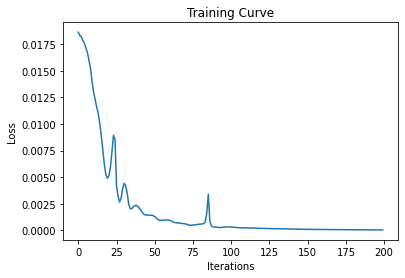

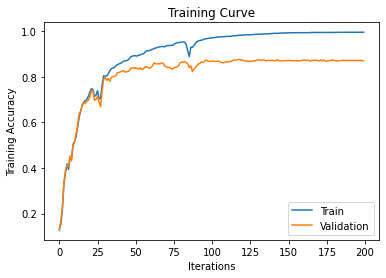

Final Training Accuracy: 0.9954642475987193
Final Validation Accuracy: 0.8696581196581197


In [ ]:
inceptionClassify = Waste_Classifier_MLP(name="Waste_InceptionMLP2", hidden_size=2048)
if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_train_set_inception, feature_val_set_inception, batch_size=128, num_epochs=200, learning_rate=0.002)

Epoch 1: Train accuracy: 0.2905549626467449, Training Loss: 0.029976295307278633, Validation Accuracy: 0.29273504273504275
Epoch 11: Train accuracy: 0.8340448239060833, Training Loss: 0.0032755641732364893, Validation Accuracy: 0.8034188034188035
Epoch 21: Train accuracy: 0.8767342582710779, Training Loss: 0.0018886880716308951, Validation Accuracy: 0.8418803418803419
Epoch 31: Train accuracy: 0.8972785485592316, Training Loss: 0.001334486179985106, Validation Accuracy: 0.844017094017094
Epoch 41: Train accuracy: 0.9114194236926361, Training Loss: 0.001049033016897738, Validation Accuracy: 0.8504273504273504
Epoch 51: Train accuracy: 0.9207577374599787, Training Loss: 0.0008794066961854696, Validation Accuracy: 0.8568376068376068
Epoch 61: Train accuracy: 0.9276947705442903, Training Loss: 0.0007679251721128821, Validation Accuracy: 0.8675213675213675
Epoch 71: Train accuracy: 0.9367662753468516, Training Loss: 0.0006887752679176629, Validation Accuracy: 0.8760683760683761
Epoch 81: Tr

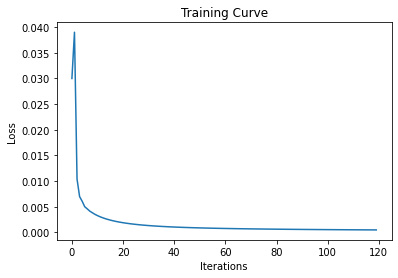

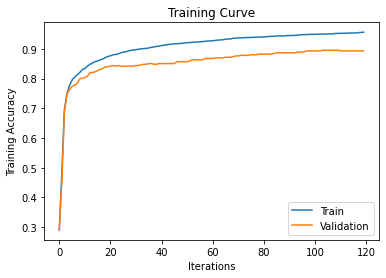

Final Training Accuracy: 0.9559765208110993
Final Validation Accuracy: 0.8931623931623932


In [ ]:
inceptionClassify = Waste_Classifier_One_Linear_Layer(name="Waste_Classifier_One_Linear_Layer", hidden_size=2048)
if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_train_set_inception, feature_val_set_inception, batch_size=128, num_epochs=120, learning_rate=0.002)

Epoch 1: Train accuracy: 0.29242262540021347, Training Loss: 0.01965285837650299, Validation Accuracy: 0.28205128205128205
Epoch 11: Train accuracy: 0.7147812166488794, Training Loss: 0.008686273358762264, Validation Accuracy: 0.7008547008547008
Epoch 21: Train accuracy: 0.8183030949839915, Training Loss: 0.003742844332009554, Validation Accuracy: 0.8034188034188035
Epoch 31: Train accuracy: 0.8636606189967982, Training Loss: 0.0022708349861204624, Validation Accuracy: 0.844017094017094
Epoch 41: Train accuracy: 0.894076840981857, Training Loss: 0.0014780188212171197, Validation Accuracy: 0.8632478632478633
Epoch 51: Train accuracy: 0.9156883671291356, Training Loss: 0.0010526675032451749, Validation Accuracy: 0.8717948717948718
Epoch 61: Train accuracy: 0.9303628601921025, Training Loss: 0.0008023665868677199, Validation Accuracy: 0.8846153846153846
Epoch 71: Train accuracy: 0.9415688367129136, Training Loss: 0.0006305573042482138, Validation Accuracy: 0.8846153846153846
Epoch 81: Tra

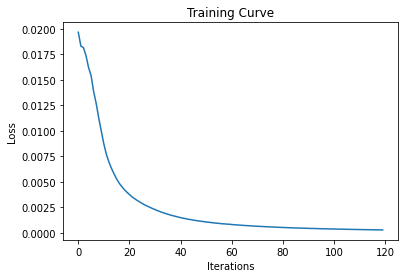

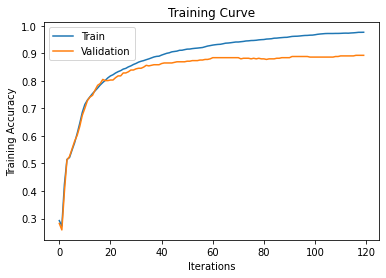

Final Training Accuracy: 0.9770544290288153
Final Validation Accuracy: 0.8931623931623932


In [ ]:
inceptionClassify = Waste_Classifier_ANN(name="Waste_InceptionANN", hidden_size=2048, actual_hidden_size=100)
if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_train_set_inception, feature_val_set_inception, batch_size=128, num_epochs=120, learning_rate=0.002)

Epoch 1: Train accuracy: 0.10795090715048025, Training Loss: 0.013464669696986675, Validation Accuracy: 0.10897435897435898
Epoch 11: Train accuracy: 0.10779082177161152, Training Loss: 0.011966773308813572, Validation Accuracy: 0.10897435897435898
Epoch 21: Train accuracy: 0.10779082177161152, Training Loss: 0.0007669720216654241, Validation Accuracy: 0.10897435897435898
Epoch 31: Train accuracy: 0.12374599786552828, Training Loss: 0.016870053485035896, Validation Accuracy: 0.11752136752136752
Epoch 41: Train accuracy: 0.117982924226254, Training Loss: 0.017018066719174385, Validation Accuracy: 0.13247863247863248
Epoch 51: Train accuracy: 0.10773745997865529, Training Loss: 0.01693965308368206, Validation Accuracy: 0.1111111111111111
Epoch 61: Train accuracy: 0.10928495197438634, Training Loss: 0.0171088594943285, Validation Accuracy: 0.11538461538461539
Epoch 71: Train accuracy: 0.10538954108858058, Training Loss: 0.016842078417539597, Validation Accuracy: 0.1047008547008547
Epoch 8

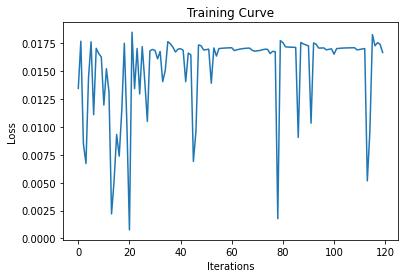

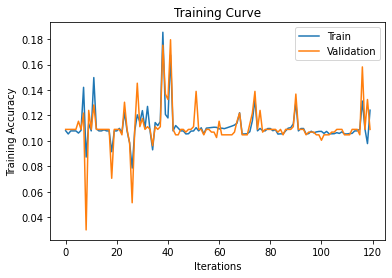

Final Training Accuracy: 0.12406616862326574
Final Validation Accuracy: 0.10897435897435898


In [ ]:
#Using data augmentation
inceptionClassify = Waste_Classifier_ANN(name="Waste_InceptionANN", hidden_size=2048, actual_hidden_size=300)
if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_train_set_inception, feature_val_set_inception, batch_size=128, num_epochs=120, learning_rate=0.002)

Epoch 1: Train accuracy: 0.10325506937033084, Training Loss: 0.017234301194548607, Validation Accuracy: 0.10256410256410256
Epoch 11: Train accuracy: 0.3850053361792956, Training Loss: 0.012422118335962296, Validation Accuracy: 0.3952991452991453
Epoch 21: Train accuracy: 0.6905016008537886, Training Loss: 0.007661683019250631, Validation Accuracy: 0.6965811965811965
Epoch 31: Train accuracy: 0.791889007470651, Training Loss: 0.003771349787712097, Validation Accuracy: 0.7756410256410257
Epoch 41: Train accuracy: 0.8444503735325507, Training Loss: 0.0023702257312834263, Validation Accuracy: 0.8247863247863247
Epoch 51: Train accuracy: 0.8740661686232657, Training Loss: 0.001695146202109754, Validation Accuracy: 0.844017094017094
Epoch 61: Train accuracy: 0.8930096051227321, Training Loss: 0.0012805371079593897, Validation Accuracy: 0.8461538461538461
Epoch 71: Train accuracy: 0.9130202774813234, Training Loss: 0.0009965947829186916, Validation Accuracy: 0.8547008547008547
Epoch 81: Trai

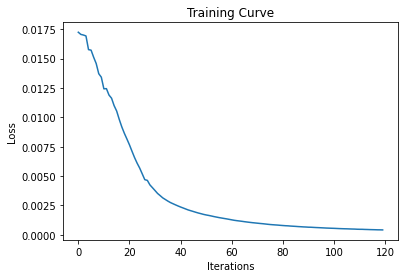

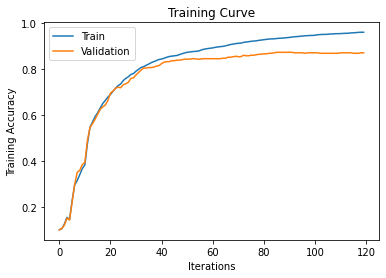

Final Training Accuracy: 0.9610458911419424
Final Validation Accuracy: 0.8717948717948718


In [ ]:
inceptionClassify = Waste_Classifier_ANN(name="Waste_InceptionANN", hidden_size=2048, actual_hidden_size=25)
if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_train_set_inception, feature_val_set_inception, batch_size=128, num_epochs=120, learning_rate=0.002)

Epoch 1: Train accuracy: 0.10779082177161152, Training Loss: 3.582009133751285e-10, Validation Accuracy: 0.10897435897435898
Epoch 11: Train accuracy: 0.3774813233724653, Training Loss: 0.00011328399705234915, Validation Accuracy: 0.47863247863247865
Epoch 21: Train accuracy: 0.46398078975453577, Training Loss: 0.00014382541121449322, Validation Accuracy: 0.5491452991452992
Epoch 31: Train accuracy: 0.5203308431163287, Training Loss: 0.00019290072668809444, Validation Accuracy: 0.5790598290598291
Epoch 41: Train accuracy: 0.5569370330843116, Training Loss: 0.00021156623552087694, Validation Accuracy: 0.6068376068376068
Epoch 51: Train accuracy: 0.5821771611526148, Training Loss: 0.00013182494149077684, Validation Accuracy: 0.6346153846153846
Epoch 61: Train accuracy: 0.6027748132337246, Training Loss: 7.125935371732339e-05, Validation Accuracy: 0.6452991452991453
Epoch 71: Train accuracy: 0.6203842049092849, Training Loss: 4.9851420044433326e-05, Validation Accuracy: 0.655982905982906


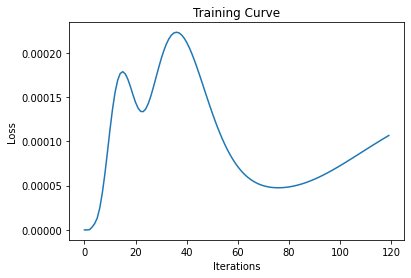

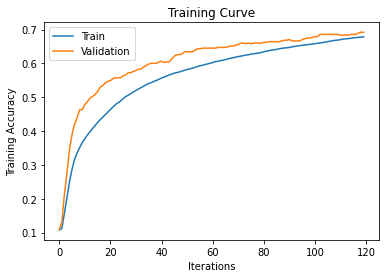

Final Training Accuracy: 0.6787086446104589
Final Validation Accuracy: 0.6923076923076923


In [ ]:
#data aug
inceptionClassify = Waste_Classifier_One_Linear_Layer(name="Waste_Classifier_One_Linear_Layer", hidden_size=2048)
if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_train_set_inception, feature_val_set_inception, batch_size=128, num_epochs=120, learning_rate=0.002)

Epoch 1: Train accuracy: 0.10779082177161152, Training Loss: 0.0, Validation Accuracy: 0.10897435897435898
Epoch 11: Train accuracy: 0.3709711846318036, Training Loss: 3.6702945180877578e-06, Validation Accuracy: 0.46153846153846156
Epoch 21: Train accuracy: 0.45352187833511204, Training Loss: 4.838145287067164e-06, Validation Accuracy: 0.5427350427350427
Epoch 31: Train accuracy: 0.5115795090715048, Training Loss: 0.00011339860066073015, Validation Accuracy: 0.5726495726495726
Epoch 41: Train accuracy: 0.5452508004268943, Training Loss: 0.00015379238175228238, Validation Accuracy: 0.6004273504273504
Epoch 51: Train accuracy: 0.5715581643543223, Training Loss: 5.82160191697767e-06, Validation Accuracy: 0.6303418803418803
Epoch 61: Train accuracy: 0.5897545357524013, Training Loss: 9.510012333180384e-09, Validation Accuracy: 0.6410256410256411
Epoch 71: Train accuracy: 0.6034151547491996, Training Loss: 5.910308353840321e-10, Validation Accuracy: 0.6474358974358975
Epoch 81: Train accur

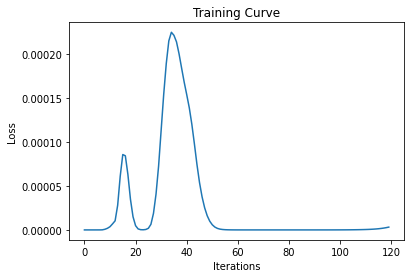

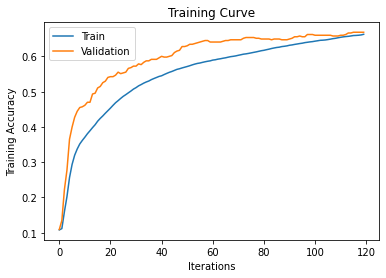

Final Training Accuracy: 0.6629669156883671
Final Validation Accuracy: 0.6688034188034188


In [ ]:
#data aug
inceptionClassify = Waste_Classifier_One_Linear_Layer(name="Waste_Classifier_One_Linear_Layer", hidden_size=2048)
if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_train_set_inception, feature_val_set_inception, batch_size=128, num_epochs=200, learning_rate=0.01)

In [ ]:
#data aug

inceptionClassify = Waste_Classifier_One_Linear_Layer(name="Waste_Classifier_One_Linear_Layer", hidden_size=2048)
state = torch.load("/content/model_Waste_Classifier_One_Linear_Layer_bs128_lr0.002_epoch119")
inceptionClassify.load_state_dict(state)

if use_cuda and torch.cuda.is_available():
  inceptionClassify = inceptionClassify.cuda()
train(inceptionClassify, feature_train_set_inception, feature_val_set_inception, batch_size=128, num_epochs=1000, learning_rate=0.002)

Epoch 1: Train accuracy: 0.6815901814300961, Training Loss: 0.0001137597719207406, Validation Accuracy: 0.6923076923076923
Epoch 11: Train accuracy: 0.6883137673425828, Training Loss: 0.0001228887413162738, Validation Accuracy: 0.7008547008547008
Epoch 21: Train accuracy: 0.6969583778014942, Training Loss: 0.0001354596170131117, Validation Accuracy: 0.6987179487179487
Epoch 31: Train accuracy: 0.7050160085378868, Training Loss: 0.00014603578893002123, Validation Accuracy: 0.7072649572649573
Epoch 41: Train accuracy: 0.7122198505869797, Training Loss: 0.0001545736304251477, Validation Accuracy: 0.717948717948718
Epoch 51: Train accuracy: 0.7192636072572038, Training Loss: 0.00016122072702273726, Validation Accuracy: 0.7200854700854701
Epoch 61: Train accuracy: 0.7262006403415154, Training Loss: 0.00016613553452771157, Validation Accuracy: 0.7200854700854701
Epoch 71: Train accuracy: 0.7336179295624333, Training Loss: 0.00016942746879067272, Validation Accuracy: 0.7286324786324786
Epoch 

KeyboardInterrupt: ignored

# Predictions and Testing --> VGG16

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.classifier = nn.Identity()
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
data_dir = '/root/datasets/VGG16/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

os.mkdir(data_dir)
model = vgg16
save_features(model, "vgg16", tiny_set, tiny_dir, tiny_set.classes)
save_features(model, "vgg16", train_set, train_dir, train_set.classes)
save_features(model, "vgg16", val_set, val_dir, val_set.classes)
save_features(model, "vgg16", test_set, test_dir, test_set.classes)

In [ ]:
feature_tiny_set_vgg16 = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set_vgg16 = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set_vgg16 = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set_vgg16 = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.16666666666666666, Training Loss: 0.07910817464192708, Validation Accuracy: 0.16666666666666666
Epoch 2: Train accuracy: 0.43333333333333335, Training Loss: 0.07488875389099121, Validation Accuracy: 0.43333333333333335
Epoch 3: Train accuracy: 0.8, Training Loss: 0.06929771105448405, Validation Accuracy: 0.8
Epoch 4: Train accuracy: 0.9333333333333333, Training Loss: 0.06319302717844645, Validation Accuracy: 0.9333333333333333
Epoch 5: Train accuracy: 1.0, Training Loss: 0.055969858169555665, Validation Accuracy: 1.0
Epoch 6: Train accuracy: 1.0, Training Loss: 0.04799492756525676, Validation Accuracy: 1.0
Epoch 7: Train accuracy: 1.0, Training Loss: 0.039623486995697024, Validation Accuracy: 1.0
Epoch 8: Train accuracy: 1.0, Training Loss: 0.031514505545298256, Validation Accuracy: 1.0
Epoch 9: Train accuracy: 1.0, Training Loss: 0.024390508731206257, Validation Accuracy: 1.0
Epoch 10: Train accuracy: 1.0, Training Loss: 0.018466482559839886, Validation Accu

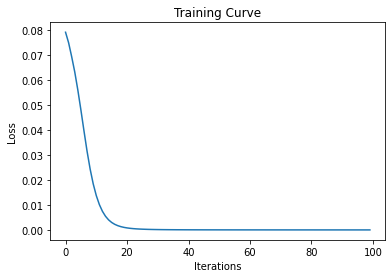

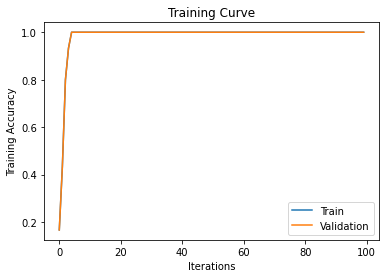

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
vgg16Classify = Waste_Classifier_ANN(name="Waste_VGG16", hidden_size=25088)
if use_cuda and torch.cuda.is_available():
  vgg16Classify = vgg16Classify.cuda()
train(vgg16Classify, feature_tiny_set_vgg16, feature_tiny_set_vgg16, batch_size=30, num_epochs=100, learning_rate=0.002)

Epoch 1: Train accuracy: 0.23559231590181431, Training Loss: 0.01843496784567833, Validation Accuracy: 0.24572649572649571
Epoch 2: Train accuracy: 0.3105656350053362, Training Loss: 0.01794353872537613, Validation Accuracy: 0.31196581196581197
Epoch 3: Train accuracy: 0.4981323372465315, Training Loss: 0.01748044788837433, Validation Accuracy: 0.48504273504273504
Epoch 4: Train accuracy: 0.5843116328708644, Training Loss: 0.016587041318416595, Validation Accuracy: 0.5555555555555556
Epoch 5: Train accuracy: 0.6486125933831377, Training Loss: 0.014840720221400261, Validation Accuracy: 0.6217948717948718
Epoch 6: Train accuracy: 0.6891675560298826, Training Loss: 0.012902353890240192, Validation Accuracy: 0.6709401709401709
Epoch 7: Train accuracy: 0.7169156883671292, Training Loss: 0.01139439269900322, Validation Accuracy: 0.6987179487179487
Epoch 8: Train accuracy: 0.7353255069370331, Training Loss: 0.01010880060493946, Validation Accuracy: 0.7094017094017094
Epoch 9: Train accuracy: 

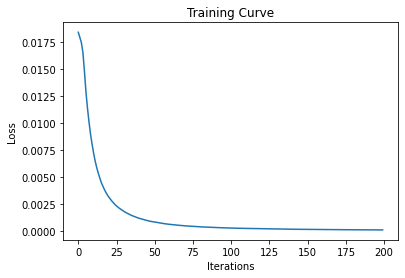

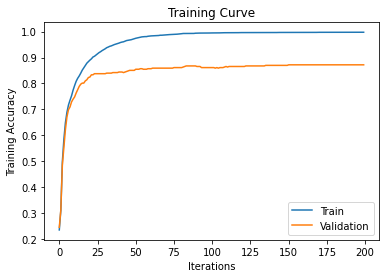

Final Training Accuracy: 0.9973319103521878
Final Validation Accuracy: 0.8717948717948718


In [ ]:
vgg16Classify = Waste_Classifier_ANN(name="Waste_VGG16", hidden_size=25088)
if use_cuda and torch.cuda.is_available():
  vgg16Classify = vgg16Classify.cuda()
train(vgg16Classify, feature_train_set_vgg16, feature_val_set_vgg16, batch_size=128, num_epochs=200, learning_rate=0.00025)

Epoch 1: Train accuracy: 0.20624332977588047, Training Loss: 0.07717180252075195, Validation Accuracy: 0.20512820512820512
Epoch 2: Train accuracy: 0.2676093916755603, Training Loss: 0.07647629082202911, Validation Accuracy: 0.2692307692307692
Epoch 3: Train accuracy: 0.3289754535752401, Training Loss: 0.07022517174482346, Validation Accuracy: 0.32051282051282054
Epoch 4: Train accuracy: 0.3783351120597652, Training Loss: 0.0648365393280983, Validation Accuracy: 0.37393162393162394
Epoch 5: Train accuracy: 0.3890074706510139, Training Loss: 0.05760527402162552, Validation Accuracy: 0.391025641025641
Epoch 6: Train accuracy: 0.4119530416221985, Training Loss: 0.052759602665901184, Validation Accuracy: 0.41452991452991456
Epoch 7: Train accuracy: 0.44957310565635006, Training Loss: 0.047910045832395554, Validation Accuracy: 0.4465811965811966
Epoch 8: Train accuracy: 0.4957310565635005, Training Loss: 0.043403301388025284, Validation Accuracy: 0.47435897435897434
Epoch 9: Train accuracy:

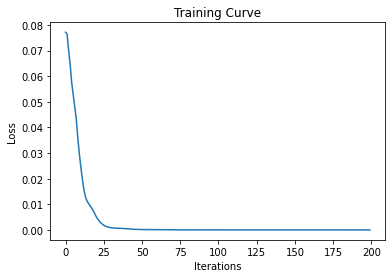

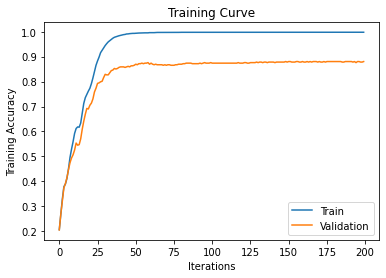

Final Training Accuracy: 0.9978655282817502
Final Validation Accuracy: 0.8803418803418803


In [ ]:
vgg16Classify = Waste_Classifier_MLP(name="Waste_VGG16", hidden_size=25088)
if use_cuda and torch.cuda.is_available():
  vgg16Classify = vgg16Classify.cuda()
train(vgg16Classify, feature_train_set_vgg16, feature_val_set_vgg16, batch_size=32, num_epochs=200, learning_rate=0.0003)

# Baseline Model: Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
forest = RandomForestClassifier(n_estimators=200, bootstrap=True, max_features='sqrt')
loader = torch.utils.data.DataLoader(tiny_set, batch_size=len(tiny_set), num_workers=1)
accuracy = 0
total = 0

for imgs, labels in loader:
  imgs = imgs.numpy()
  labels = labels.numpy()
  imgs = imgs.reshape((imgs.shape[0], imgs.shape[1]*imgs.shape[2]*imgs.shape[3]))

  forest.fit(imgs, labels)
  predictions = forest.predict(imgs)

  accuracy += accuracy_score(predictions, labels)
  total += 1
print("Overfit accuracy:", accuracy/total)


Overfit accuracy: 1.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
forest = RandomForestClassifier(n_estimators=200, bootstrap=True, max_features='sqrt')
loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), num_workers=1)
accuracy = 0
total = 0

for imgs, labels in loader:
  imgs = imgs.numpy()
  labels = labels.numpy()
  imgs = imgs.reshape((imgs.shape[0], imgs.shape[1]*imgs.shape[2]*imgs.shape[3]))
  forest.fit(imgs, labels)

  val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), num_workers=1)
  for val_imgs, val_labels in val_loader:
    val_imgs = val_imgs.numpy()
    val_labels = val_labels.numpy()
    val_imgs = val_imgs.reshape((val_imgs.shape[0], val_imgs.shape[1]*val_imgs.shape[2]*val_imgs.shape[3]))
    predictions = forest.predict(val_imgs)
    accuracy += accuracy_score(predictions, val_labels)
    total += 1

print("Overfit accuracy:", accuracy/total)

Overfit accuracy: 0.5833333333333334


In [ ]:
accuracy = 0
total = 0
forest = RandomForestClassifier(n_estimators=200, bootstrap=True, max_features='sqrt')
loader = torch.utils.data.DataLoader(train_set, batch_size=int(len(train_set)/2), num_workers=1)
for imgs, labels in loader:
  imgs = imgs.numpy()
  labels = labels.numpy()
  imgs = imgs.reshape((imgs.shape[0], imgs.shape[1]*imgs.shape[2]*imgs.shape[3]))
  forest.fit(imgs, labels)

  val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), num_workers=1)
  for val_imgs, val_labels in val_loader:
    val_imgs = val_imgs.numpy()
    val_labels = val_labels.numpy()
    val_imgs = val_imgs.reshape((val_imgs.shape[0], val_imgs.shape[1]*val_imgs.shape[2]*val_imgs.shape[3]))
    predictions = forest.predict(val_imgs)
    accuracy += accuracy_score(predictions, val_labels)
    total += 1
print("Overfit accuracy:", accuracy/total)

Overfit accuracy: 0.344017094017094
